In [140]:
# if pip install isnt working:
# !python --version

# !curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
# !python get-pip.py


add citations to functions!

In [141]:

# requirements:
#!python -m 
! pip install pandas yfinance requests numpy matplotlib PyWavelets seaborn scikit-learn scipy statsmodels tensorflow tqdm ipywidgets boruta
# import the necessary libraries.
import requests
import pywt
import os
import time
import warnings
    
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import seaborn as sns
from joblib import Parallel, delayed
    
from boruta import BorutaPy
from statsmodels.robust import mad
from tqdm.notebook import tqdm  # For Jupyter Notebooks

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.base import clone

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, LayerNormalization, MultiHeadAttention, Add, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Partly due to unavailability of a suitable dataset that the specific use case of this project, the case study this project was designed around created their own dataset by using the yfinance (yahoo finance) library to get the stock market and bitcoin data required for this project. In future I would like to include more varied sources data sources such as those from Tiingo, to fall more in line with the case study.

To start with we'll define a directory for the datasets.csv that will need to be generated.

In [142]:
project_root = Path(os.getcwd()) # find file path of the working directory for notebook scripts.
output_dir = project_root / "dataset"
# check to see if the directory exists, make it if it doesn't
output_dir.mkdir(parents=True, exist_ok=True)

# create two additional directories, for chart outputs.
data_visualizations = project_root / "dataset" / "charts" / "data_visualizations"
denoising = project_root / "dataset" / "charts" / "denoising"
evaluation_metrics = project_root / "dataset" / "charts" / "evaluation_metrics"

data_visualizations.mkdir(parents=True, exist_ok=True)
denoising.mkdir(parents=True, exist_ok=True)
evaluation_metrics.mkdir(parents=True, exist_ok=True)

# define output path for csv files.
output_path = output_dir / "2015-2025_dataset.csv"

# defining the date range for the dataset.
start_date = "2015-01-01"
end_date = "2025-02-01"

date_range = pd.date_range(start=start_date, end=end_date, freq='D') # Format: YYYY-MM-DD, "freq" is the frequency of dates in this case: ='D' means daily.

# create data frame
df = pd.DataFrame(index=date_range)

we'll need to define a few functions that are needed before we can generate the completed dataset. Using the yahoo finance API, this block pulls the historical trading data needed for each individual major global stock exhange for volume and closed price, then converted the currencies to USD using forex data (also from the yfinance API) and returns the results. 

With some minor assistance from Claude sonnet 3.5 (Claude, 2025)

In [143]:
def fetch_stock_data(symbol: str, currency: str, start_date: str, end_date: str) -> pd.DataFrame: # (Claude, 2025)
    # yf.download is the synax for yfinance to pull data directly through python, "symbol" for the kind of data, be it a currency or a company name etc. (Documentation for the API can be found here: https://yfinance-python.org/) 
    df = yf.download(symbol, start=start_date, end=end_date)
    if df.empty:
        return pd.DataFrame(index=date_range)
        
    # Create a new DataFrame with just Close and Volume
    result = pd.DataFrame(index=df.index)
    result['Close'] = df['Close']
    result['Volume'] = df['Volume']
    
    # Get currency conversion rate if needed
    if currency:
        fx_data = yf.download(currency, start=start_date, end=end_date)
        if not fx_data.empty:
            fx_rate = fx_data['Close']
            
            # Ensure both dataframes have datetime index
            result.index = pd.to_datetime(result.index)
            fx_rate.index = pd.to_datetime(fx_rate.index)
            
            # Find common dates between stock and forex data
            common_dates = result.index.intersection(fx_rate.index)            
            # Keep only dates where we have both stock and forex data
            result = result.loc[common_dates]
            fx_rate = fx_rate.loc[common_dates]
            
            # Convert only Close prices to USD using element-wise multiplication
            result['Close'] = result['Close'].values * fx_rate.values
        else:
            return pd.DataFrame(index=date_range)
    
    # Handle volume based on the index
    if symbol in ['^N225', '^HSI']:  # Asian markets often have lower nominal volumes
        result['Volume'] = result['Volume'] / 1_000  # Convert to thousands
    else:
        result['Volume'] = result['Volume'] / 1_000_000  # Convert to millions
                
    # Add sanity checks for extreme values
    if result['Close'].max() > 50000 or result['Close'].min() < 1:
        return pd.DataFrame(index=date_range)
        
    if result['Volume'].min() == 0 or result['Volume'].max() / result['Volume'].min() > 1000:
        return pd.DataFrame(index=date_range)
        
    # Rename columns with symbol prefix
    result = result.rename(columns={
        'Close': f'{symbol}_Close_USD',
        'Volume': f'{symbol}_Volume_M'  # M for millions or thousands for Asian markets
    })
    
    # Reindex to full date range without filling
    result = result.reindex(date_range)
    return result

This function iteratively passes the "symbol" required to pull the seven stock market historical data that was chosen for inclusion in the dataset. After aquiring the entire daily closed USD price and volume data for each exchange, the data is then averaged together into two combined columns for the previously specified time frame.

- "(Tang et al.) demonstrates strong correlations between global market indices and crypto markets" 
- "The inclusion of Asian markets (Nikkei, Hang Seng) is particularly relevant as studies have shown significant Bitcoin trading volume from these regions" 
- "The SKEW index; research shows its effectiveness in predicting "black swan" events in crypto markets, OVX (Oil Volatility) "Enhancing Bitcoin Price Prediction with Deep Learning" shows volatility indices are key predictors"

- ""Cryptocurrency Valuation: An Explainable AI Approach" validates the use of on-chain metrics as fundamental indicators" - "Hash rate and mining difficulty are particularly important as they reflect network security and mining economics"
- "Transaction metrics provide insight into network usage and adoption"

- "Deep Learning for Financial Applications: A Survey" supports the inclusion of traditional safe-haven assets like gold, The DXY (Dollar Index) inclusion is supported by research showing strong inverse correlations with Bitcoin during certain market conditions"

In [144]:
def get_market_stock_data(start_date, end_date): # Some minor logical assistance from Claude AI was used her for yfinance AI syntax. (Claude, 2025)
    # date range and data frame: 
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    result_df = pd.DataFrame(index=date_range)
    
    # Define indices of each market symbol with corresponding currency symbol.
    indices = {
        'GDAXI': {'symbol': '^GDAXI', 'currency': 'EURUSD=X'},    # Germany DAX
        'IXIC': {'symbol': '^IXIC', 'currency': None},            # NASDAQ (already in USD)
        'DJI': {'symbol': '^DJI', 'currency': None},              # Dow Jones (already in USD)
        'N225': {'symbol': '^N225', 'currency': 'JPYUSD=X'},      # Nikkei
        'STOXX50E': {'symbol': '^STOXX', 'currency': 'EURUSD=X'}, # Euro STOXX 50
        'HSI': {'symbol': '^HSI', 'currency': 'HKDUSD=X'},        # Hang Seng
        'FTSE': {'symbol': '^FTSE', 'currency': 'GBPUSD=X'}       # FTSE 100
    }
    
    # Define a second data frame for later
    combined_df = pd.DataFrame(index=date_range)
    
    for index_name, info in indices.items():
        index_data = fetch_stock_data(info['symbol'], info['currency'], start_date, end_date)
        if not index_data.empty and len(index_data.columns) > 0:
            combined_df = pd.concat([combined_df, index_data], axis=1)
    
    # Collect only the columns we need for the dataset.
    close_cols = [col for col in combined_df.columns if str(col).endswith('_Close_USD')]
    volume_cols = [col for col in combined_df.columns if str(col).endswith('_Volume_M')]
    
    # Perform the mean average calculations on the columns.
    if close_cols and volume_cols:
        result_df = pd.DataFrame(index=date_range)
        result_df['Global averaged stocks(USD)'] = combined_df[close_cols].mean(axis=1, skipna=True)
        result_df['Global averaged stocks (volume)'] = combined_df[volume_cols].mean(axis=1, skipna=True)
        
        return result_df
    return pd.DataFrame(index=date_range, columns=['Global averaged stocks(USD)', 'Global averaged stocks (volume)'])

This next function works similar to the previous, collecting the US Dollar index (DXY) and the gold futures data from Yahoo Finance. Along with the Bitcoin-USD paring with its respective volume data.

In [145]:
def get_currency_metrics(start_date, end_date):  
    
    # Another new dataframe
    result_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Collect the DXY (US Dollar Index) historical data.
    dxy = yf.download("DX-Y.NYB", start=start_date, end=end_date)
    result_df['Currency US Dollar Index'] = dxy['Close']
    
    # Collect the Gold Futures historical data.
    gold = yf.download("GC=F", start=start_date, end=end_date)
    result_df['Currency Gold Futures'] = gold['Close']
    
    # Collect the Bitcoin price historical data.
    btc = yf.download("BTC-USD", start=start_date, end=end_date)
    result_df['BTC/USD'] = btc['Close']
    
    # Collect the Bitcoin volume historical data.
    btc = yf.download("BTC-USD", start=start_date, end=end_date)
    result_df['BTC Volume'] = btc['Volume']
    
    # Figure out the Gold/BTC ratio buy using already collected data, where BTC price is not zero or null.
    result_df['Gold/BTC Ratio'] = result_df['Currency Gold Futures'].div(result_df['BTC/USD'].replace(0, float('nan')))
    result_df['Gold/BTC Ratio'] = result_df['Gold/BTC Ratio']
    
    return result_df

Same again here, with some additional assistence from Claude AI for the fiddly API syntax (Claude, 2025), and using the blockchain.info API, this function collects the individual "on chain" metrics.

In [146]:
def get_blockchain_metric(metric_name, start_date, end_date): # (Claude, 2025)
    
    # Fetch single blockchain metric one by one, from the Blockchain.info API.
 
    # Convert dates to timestamps
    start_ts = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp())
    end_ts = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    
    # Fetch data from API with updated URL structure
    url = f"{"https://api.blockchain.info"}/{metric_name}"
    params = {
        "timespan": "all",
        "start": start_ts,
        "end": end_ts,
        "format": "json",
        "sampled": "true"
    }
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
        
    data = response.json()
    
    # Check if the response has the expected structure
    if not isinstance(data, dict) or 'values' not in data:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Process the values
    values = []
    timestamps = []
    for entry in data['values']:
        if isinstance(entry, (list, tuple)) and len(entry) >= 2:
            timestamps.append(entry[0])
            values.append(float(entry[1]))
        elif isinstance(entry, dict) and 'x' in entry and 'y' in entry:
            timestamps.append(entry['x'])
            values.append(float(entry['y']))
    
    if not values:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Create DataFrame and handle data types
    df = pd.DataFrame({'timestamp': timestamps, 'value': values})
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.normalize()
    df = df.drop_duplicates('timestamp', keep='last')
    df.set_index('timestamp', inplace=True)
    
    # Handle potential overflow for large numbers
    df['value'] = df['value'].astype('float64')
    
    # Reindex to ensure consistent date range
    return df['value'].reindex(date_range)

This function calls the previous block iteratively for each metric of "on chain" data, with some minor assistence from Caude AI for syntax errors. (Claude, 2025)

In [147]:
def get_onchain_metrics(start_date, end_date): # (Claude, 2025)
    result_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    # Define metrics and their API endpoints with updated paths
    metrics = {
        'Onchain Active Addresses': 'charts/n-unique-addresses',
        'Onchain Transaction Count': 'charts/n-transactions',
        'Onchain Hash Rate (GH/s)': 'charts/hash-rate',
        'Onchain Mining Difficulty': 'charts/difficulty',
        'Onchain Transaction Fees (BTC)': 'charts/transaction-fees',
        'Onchain Median Confirmation Time (min)': 'charts/median-confirmation-time'
    }
    
    # Fetch each metric
    for col_name, metric_name in metrics.items():
        series = get_blockchain_metric(metric_name, start_date, end_date)
        result_df[col_name] = series
        
        # Handle missing values for each metric appropriately
        if col_name in ['Onchain Mining Difficulty', 'Onchain Hash Rate (GH/s)']:
            result_df[col_name] = result_df[col_name]
        elif col_name in ['Onchain Transaction Count', 'Onchain Active Addresses']:
            result_df[col_name] = result_df[col_name]
        else:
            result_df[col_name] = result_df[col_name]
    
    return result_df

These additional metrics track the volatility of the S&P500 stock market and the crude oil volatility index.

In [148]:
def get_volatility_indices(start_date, end_date):    
    df = pd.DataFrame()
    
    # Collect the CBOE SKEW index from Yahoo Finance
    skew = yf.download("^SKEW", start=start_date, end=end_date)
    df['Volatility_CBOE SKEW Index'] = skew['Close']
    
    # Collect the VIX index from Yahoo Finance 
    vix = yf.download("^VIX", start=start_date, end=end_date)
    df['Volatility_CBOE Volatility Index (VIX)'] = vix['Close']
    
    # Collect the Oil VIX index from Yahoo Finance 
    ovx = yf.download("^OVX", start=start_date, end=end_date)
    df['Volatility_Crude Oil Volatility Index (OVX)'] = ovx['Close']
    
    return df

https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25

https://medium.com/@100trillionUSD/bitcoin-stock-to-flow-cross-asset-model-50d260feed12

https://newhedge.io/bitcoin/stock-to-flow

Here we includ and calculate the "Stock to Flow" model intially conceptualized by "PlanB".

Largely assisted by Claude AI for the math and syntax (Claude, 2025).

In [149]:
def calculate_stock_to_flow(start_date, end_date): # (Claude, 2025)
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    s2f_df = pd.DataFrame(index=date_range)
    
    # API parameters
    params = {
        "timespan": "all",
        "start": int(pd.Timestamp(start_date).timestamp()),
        "end": int(pd.Timestamp(end_date).timestamp()),
        "format": "json",
        "sampled": "false"
    }
    
    # Get total supply
    response = requests.get("https://api.blockchain.info/charts/total-bitcoins", params=params)
    if response.status_code == 200:
        data = response.json()['values']
        df = pd.DataFrame(data, columns=['x', 'y'])
        df['timestamp'] = pd.to_datetime(df['x'], unit='s').dt.normalize()
        stock = df.groupby('timestamp')['y'].mean()
        stock = stock.reindex(date_range).interpolate(method='linear')
        
        # Calculate flow based on Bitcoin halving schedule
        s2f_df['timestamp'] = date_range
        s2f_df['block height'] = ((s2f_df['timestamp'] - pd.Timestamp('2009-01-03')) / pd.Timedelta(minutes=10)).astype(int) # "genesis block" date (January 3, 2009) the first BTC block to be mined.
        
        # Calculate daily block rewards based on halving schedule
        def get_block_reward(block_height):
            halvings = block_height // 210000 # Roughly every 4 years there is a BTC "halving event" (when the mining rewards are halved) this is every 210,000 blocks.
            return 50 / (2 ** halvings)
        
        s2f_df['daily production'] = s2f_df['block height'].apply(get_block_reward) * 144  # Timing by 144 gives us the total daily Bitcoin production (24 hours * 60 minutes) / 10 minutes = 144 blocks per day, ".apply(get_block_reward)" calculates the reward for each block height.
        
        # Calculate S2F ratio (stock divided by yearly flow)
        s2f_df['s2f ratio'] = stock / (s2f_df['daily production'] * 365)
        
        # Calculate expected price using S2F model
        # Using the formula: Price = exp(-1.84) * S2F^3.36
        s2f_df['S2F Model'] = np.exp(-1.84) * (s2f_df['s2f ratio'] ** 3.36)
        
        # Convert to USD and handle any extreme values
        s2f_df['S2F Model'] = s2f_df['S2F Model']
        
        return s2f_df[['S2F Model']]
    
    return pd.DataFrame(index=date_range)

Main fuction for compiling, saving and ordering all the columns required for this dataset.

In [150]:
# Collect all the data from the functions we created earlier, into the tuple list.
tuple_list = [
    ('Stockmarket', get_market_stock_data(start_date, end_date)),
    ('Currency Metrics', get_currency_metrics(start_date, end_date)),
    ('On-chain Metrics', get_onchain_metrics(start_date, end_date)),
    ('Volatility Indices', get_volatility_indices(start_date, end_date)),
    ('S2F Model', calculate_stock_to_flow(start_date, end_date))
    ]

# Combine all the data check for empty columns.
for name, tuple_df in tuple_list:
    if tuple_df is not None and not tuple_df.empty:
        for column in tuple_df.columns:
            df[column] = tuple_df[column]

# Reorder the columns, group related metrics together.
column_order = [
    'Global averaged stocks(USD)',
    'Global averaged stocks (volume)',
    'Currency US Dollar Index',
    'Currency Gold Futures',
    'Volatility_CBOE SKEW Index',
    'Volatility_CBOE Volatility Index (VIX)',
    'Volatility_Crude Oil Volatility Index (OVX)',
    'Gold/BTC Ratio',
    'BTC/USD',
    'BTC Volume',
    'S2F Model',
    'Onchain Active Addresses',
    'Onchain Transaction Count',
    'Onchain Hash Rate (GH/s)',
    'Onchain Mining Difficulty',
    'Onchain Transaction Fees (BTC)',
    'Onchain Median Confirmation Time (min)'
]

# Reorder the columns
df = df[column_order]

# Save the dataset
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path)
print(f"Dataset saved to {output_path}")
print(f"Shape: {df.shape}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Dataset saved to e:\Documents\skool work\Msc\AI module\Msc-COM7003-AI-Model\dataset\2015-2025_dataset.csv
Shape: (3685, 17)


"Shape: (3685, 17)" tells us that we have collected all the required columns for the dataset. We should have a dataset that is largly complete, except for missing entries in the weekends for stockmarket data as trading closes on the weekends, unlike crypto which trades 24/7. We can easily view missing data in the CSV file by using "print("missing data by column:")" and "print(df.isna().sum())". 

Additionally since we are using financial sequencial data (or time series forecasting) for the models we'll be training, duplicate data is generally less of a concern however its good practice to verify the quality and integrity of the dataset regardless and the unique entries with "df.unique()" (then view "df.head()" to see the first five values in the dataset).

In [151]:
df = pd.read_csv(output_path, index_col=0, parse_dates=True)

# Print data by by column
print("missing data by column: ")
print(df.isna().sum(), "\n")

# Print duplicates by column
print("duplicates by column: ")
print(df.duplicated(subset=None, keep='first').sum())

print("\nduplicates: ")
print(df[df.duplicated(keep='first')])

#Print unique values by column
print("\nunique: ")
print(df.nunique())

# display first five entries
df.head()

missing data by column: 
Global averaged stocks(USD)                    1149
Global averaged stocks (volume)                1149
Currency US Dollar Index                       1149
Currency Gold Futures                          1151
Volatility_CBOE SKEW Index                     1247
Volatility_CBOE Volatility Index (VIX)         1247
Volatility_Crude Oil Volatility Index (OVX)    1248
Gold/BTC Ratio                                 1151
BTC/USD                                           1
BTC Volume                                        1
S2F Model                                         0
Onchain Active Addresses                       1844
Onchain Transaction Count                      1842
Onchain Hash Rate (GH/s)                       1842
Onchain Mining Difficulty                      1842
Onchain Transaction Fees (BTC)                 1842
Onchain Median Confirmation Time (min)         1842
dtype: int64 

duplicates by column: 
0

duplicates: 
Empty DataFrame
Columns: [Global aver

Global averaged stocks(USD)  Global averaged stocks (volume)  \
2015-01-01                          NaN                              NaN   
2015-01-02                 11279.900146                          755.710   
2015-01-03                          NaN                              NaN   
2015-01-04                          NaN                              NaN   
2015-01-05                 11077.110107                          955.315   

            Currency US Dollar Index  Currency Gold Futures  \
2015-01-01                       NaN                    NaN   
2015-01-02                 91.080002            1186.000000   
2015-01-03                       NaN                    NaN   
2015-01-04                       NaN                    NaN   
2015-01-05                 91.379997            1203.900024   

            Volatility_CBOE SKEW Index  \
2015-01-01                         NaN   
2015-01-02                  128.660004   
2015-01-03                         NaN   
2015-01-04                         NaN   
2015-01-05                  127.790001   

            Volatility_CBOE Volatility Index (VIX)  \
2015-01-01                                     NaN   
2015-01-02                               17.790001   
2015-01-03                                     NaN   
2015-01-04                                     NaN   
2015-01-05                               19.920000   

            Volatility_Crude Oil Volatility Index (OVX)  Gold/BTC Ratio  \
2015-01-01                                          NaN             NaN   
2015-01-02                                    54.250000        3.764697   
2015-01-03                                          NaN             NaN   
2015-01-04                                          NaN             NaN   
2015-01-05                                    57.669998        4.386208   

               BTC/USD  BTC Volume   S2F Model  Onchain Active Addresses  \
2015-01-01  314.248993   8036550.0  415.891844                  117529.0   
2015-01-02  315.032013   7860650.0  416.317366                       NaN   
2015-01-03  281.082001  33054400.0  416.729918                  205926.0   
2015-01-04  264.195007  55629100.0  417.156111                       NaN   
2015-01-05  274.473999  43962800.0  417.583604                  200612.0   

            Onchain Transaction Count  Onchain Hash Rate (GH/s)  \
2015-01-01                    59344.0             335365.290092   
2015-01-02                        NaN                       NaN   
2015-01-03                    82227.0             331324.744428   
2015-01-04                        NaN                       NaN   
2015-01-05                    95585.0             339405.835756   

            Onchain Mining Difficulty  Onchain Transaction Fees (BTC)  \
2015-01-01               4.064096e+10                        8.054165   
2015-01-02                        NaN                             NaN   
2015-01-03               4.064096e+10                       11.798413   
2015-01-04                        NaN                             NaN   
2015-01-05               4.064096e+10                       16.091355   

            Onchain Median Confirmation Time (min)  
2015-01-01                                7.150000  
2015-01-02                                     NaN  
2015-01-03                                6.433333  
2015-01-04                                     NaN  
2015-01-05                                6.816667

It appears the "on chain metrics" are also missing data (every other day), it is here that we begin the process of "cleaning" the data, we'll start by remedying the missing entries with linear interpolation. This creating a smooth transition of values between the missing data in the dataset, crusially preserving the original data's time series characteristics. 

We would otherwise lose fidelity if the sequence of entries were to become incorrectly scaled by dropping empty rows, or unintentionally added new characteristics to the data by using averages to fill the empty rows. Using backward or forward fill would also be sub optimal as it duplicates values creating unrepresentative square wave patterns not typical of financial market data.

In [152]:
# Load the saved dataset
df = pd.read_csv(output_path, index_col=0, parse_dates=True)

# Interpolate each column based on its data type
for column in df.columns:
    # For all other metrics (prices, volumes, etc), use linear interpolation
    df[column] = df[column].interpolate(method='linear', limit=5)

# Save the interpolated dataset with a new name
interpolated_path = output_dir / "2015-2025_dataset_interpolated.csv"
df.to_csv(interpolated_path)

print(f"\nInterpolated dataset saved to {interpolated_path}")
print(f"Shape: {df.shape}")

# display first five entries, validation.
df.head()


Interpolated dataset saved to e:\Documents\skool work\Msc\AI module\Msc-COM7003-AI-Model\dataset\2015-2025_dataset_interpolated.csv
Shape: (3685, 17)


Global averaged stocks(USD)  Global averaged stocks (volume)  \
2015-01-01                          NaN                              NaN   
2015-01-02                 11279.900146                          755.710   
2015-01-03                 11212.303467                          822.245   
2015-01-04                 11144.706787                          888.780   
2015-01-05                 11077.110107                          955.315   

            Currency US Dollar Index  Currency Gold Futures  \
2015-01-01                       NaN                    NaN   
2015-01-02                 91.080002            1186.000000   
2015-01-03                 91.180000            1191.966675   
2015-01-04                 91.279999            1197.933350   
2015-01-05                 91.379997            1203.900024   

            Volatility_CBOE SKEW Index  \
2015-01-01                         NaN   
2015-01-02                  128.660004   
2015-01-03                  128.370003   
2015-01-04                  128.080002   
2015-01-05                  127.790001   

            Volatility_CBOE Volatility Index (VIX)  \
2015-01-01                                     NaN   
2015-01-02                               17.790001   
2015-01-03                               18.500001   
2015-01-04                               19.210000   
2015-01-05                               19.920000   

            Volatility_Crude Oil Volatility Index (OVX)  Gold/BTC Ratio  \
2015-01-01                                          NaN             NaN   
2015-01-02                                    54.250000        3.764697   
2015-01-03                                    55.389999        3.971867   
2015-01-04                                    56.529999        4.179038   
2015-01-05                                    57.669998        4.386208   

               BTC/USD  BTC Volume   S2F Model  Onchain Active Addresses  \
2015-01-01  314.248993   8036550.0  415.891844                  117529.0   
2015-01-02  315.032013   7860650.0  416.317366                  161727.5   
2015-01-03  281.082001  33054400.0  416.729918                  205926.0   
2015-01-04  264.195007  55629100.0  417.156111                  203269.0   
2015-01-05  274.473999  43962800.0  417.583604                  200612.0   

            Onchain Transaction Count  Onchain Hash Rate (GH/s)  \
2015-01-01                    59344.0             335365.290092   
2015-01-02                    70785.5             333345.017260   
2015-01-03                    82227.0             331324.744428   
2015-01-04                    88906.0             335365.290092   
2015-01-05                    95585.0             339405.835756   

            Onchain Mining Difficulty  Onchain Transaction Fees (BTC)  \
2015-01-01               4.064096e+10                        8.054165   
2015-01-02               4.064096e+10                        9.926289   
2015-01-03               4.064096e+10                       11.798413   
2015-01-04               4.064096e+10                       13.944884   
2015-01-05               4.064096e+10                       16.091355   

            Onchain Median Confirmation Time (min)  
2015-01-01                                7.150000  
2015-01-02                                6.791667  
2015-01-03                                6.433333  
2015-01-04                                6.625000  
2015-01-05                                6.816667

The next important step is to process the data, we'll need to normalize it making it more machine readable and comparable between columns. We will also re run the interp to attempt to fill the missing values in the first row.

In [153]:
df = pd.read_csv(output_dir / "2015-2025_dataset_interpolated.csv", index_col=0, parse_dates=True)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Create a copy of the dataframe and normalize all columns
df_normalized = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

# Save as new
df_normalized.to_csv(output_dir / "2015-2025_dataset_normalized.csv")

# display first five entries, validation.
df_normalized.head()

df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)

# Interpolate each column based on its data type
for column in df.columns:
    # For all other metrics (prices, volumes, etc), use linear interpolation
    df[column] = df[column].interpolate(method='linear', limit=20, limit_direction='backward')


# Save the interpolated dataset with a new name
df_re_norm = output_dir / "2015-2025_dataset_normalized.csv"

df.to_csv(df_re_norm)

print(f"\nInterpolated dataset saved to {interpolated_path}")
print(f"Shape: {df.shape}")

# display first five entries, validation.
df.head()



Interpolated dataset saved to e:\Documents\skool work\Msc\AI module\Msc-COM7003-AI-Model\dataset\2015-2025_dataset_interpolated.csv
Shape: (3685, 17)


Global averaged stocks(USD)  Global averaged stocks (volume)  \
2015-01-01                     0.058738                         0.057694   
2015-01-02                     0.058738                         0.057694   
2015-01-03                     0.055722                         0.067741   
2015-01-04                     0.052706                         0.077787   
2015-01-05                     0.049690                         0.087833   

            Currency US Dollar Index  Currency Gold Futures  \
2015-01-01                  0.097571               0.076289   
2015-01-02                  0.097571               0.076289   
2015-01-03                  0.101489               0.079656   
2015-01-04                  0.105408               0.083023   
2015-01-05                  0.109326               0.086390   

            Volatility_CBOE SKEW Index  \
2015-01-01                    0.262652   
2015-01-02                    0.262652   
2015-01-03                    0.258495   
2015-01-04                    0.254337   
2015-01-05                    0.250179   

            Volatility_CBOE Volatility Index (VIX)  \
2015-01-01                                0.117607   
2015-01-02                                0.117607   
2015-01-03                                0.127260   
2015-01-04                                0.136914   
2015-01-05                                0.146567   

            Volatility_Crude Oil Volatility Index (OVX)  Gold/BTC Ratio  \
2015-01-01                                     0.118422        0.541534   
2015-01-02                                     0.118422        0.541534   
2015-01-03                                     0.122132        0.571533   
2015-01-04                                     0.125842        0.601532   
2015-01-05                                     0.129552        0.631531   

             BTC/USD    BTC Volume     S2F Model  Onchain Active Addresses  \
2015-01-01  0.001285  5.011966e-07  0.000000e+00                  0.000000   
2015-01-02  0.001292  0.000000e+00  2.717128e-07                  0.046265   
2015-01-03  0.000972  7.178523e-05  5.351443e-07                  0.092530   
2015-01-04  0.000812  1.361079e-04  8.072860e-07                  0.089749   
2015-01-05  0.000909  1.028668e-04  1.080257e-06                  0.086968   

            Onchain Transaction Count  Onchain Hash Rate (GH/s)  \
2015-01-01                   0.000000                  0.000107   
2015-01-02                   0.013187                  0.000105   
2015-01-03                   0.026373                  0.000103   
2015-01-04                   0.034071                  0.000107   
2015-01-05                   0.041768                  0.000111   

            Onchain Mining Difficulty  Onchain Transaction Fees (BTC)  \
2015-01-01                        0.0                        0.002585   
2015-01-02                        0.0                        0.003840   
2015-01-03                        0.0                        0.005095   
2015-01-04                        0.0                        0.006534   
2015-01-05                        0.0                        0.007973   

            Onchain Median Confirmation Time (min)  
2015-01-01                                0.173198  
2015-01-02                                0.159608  
2015-01-03                                0.146018  
2015-01-04                                0.153287  
2015-01-05                                0.160556

Unfortunately there are still missing values in "on chain mining dificulty" so we'll resort to back and farward filling any remaining missing values with "bfill() and .ffill()".

In [154]:
df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)
df = df.bfill().ffill() # back and forward fill.

df_save = output_dir / "2015-2025_dataset_normalized.csv"

# save the data frame.
df.to_csv(df_save)

# validate
df.head()

Global averaged stocks(USD)  Global averaged stocks (volume)  \
2015-01-01                     0.058738                         0.057694   
2015-01-02                     0.058738                         0.057694   
2015-01-03                     0.055722                         0.067741   
2015-01-04                     0.052706                         0.077787   
2015-01-05                     0.049690                         0.087833   

            Currency US Dollar Index  Currency Gold Futures  \
2015-01-01                  0.097571               0.076289   
2015-01-02                  0.097571               0.076289   
2015-01-03                  0.101489               0.079656   
2015-01-04                  0.105408               0.083023   
2015-01-05                  0.109326               0.086390   

            Volatility_CBOE SKEW Index  \
2015-01-01                    0.262652   
2015-01-02                    0.262652   
2015-01-03                    0.258495   
2015-01-04                    0.254337   
2015-01-05                    0.250179   

            Volatility_CBOE Volatility Index (VIX)  \
2015-01-01                                0.117607   
2015-01-02                                0.117607   
2015-01-03                                0.127260   
2015-01-04                                0.136914   
2015-01-05                                0.146567   

            Volatility_Crude Oil Volatility Index (OVX)  Gold/BTC Ratio  \
2015-01-01                                     0.118422        0.541534   
2015-01-02                                     0.118422        0.541534   
2015-01-03                                     0.122132        0.571533   
2015-01-04                                     0.125842        0.601532   
2015-01-05                                     0.129552        0.631531   

             BTC/USD    BTC Volume     S2F Model  Onchain Active Addresses  \
2015-01-01  0.001285  5.011966e-07  0.000000e+00                  0.000000   
2015-01-02  0.001292  0.000000e+00  2.717128e-07                  0.046265   
2015-01-03  0.000972  7.178523e-05  5.351443e-07                  0.092530   
2015-01-04  0.000812  1.361079e-04  8.072860e-07                  0.089749   
2015-01-05  0.000909  1.028668e-04  1.080257e-06                  0.086968   

            Onchain Transaction Count  Onchain Hash Rate (GH/s)  \
2015-01-01                   0.000000                  0.000107   
2015-01-02                   0.013187                  0.000105   
2015-01-03                   0.026373                  0.000103   
2015-01-04                   0.034071                  0.000107   
2015-01-05                   0.041768                  0.000111   

            Onchain Mining Difficulty  Onchain Transaction Fees (BTC)  \
2015-01-01                        0.0                        0.002585   
2015-01-02                        0.0                        0.003840   
2015-01-03                        0.0                        0.005095   
2015-01-04                        0.0                        0.006534   
2015-01-05                        0.0                        0.007973   

            Onchain Median Confirmation Time (min)  
2015-01-01                                0.173198  
2015-01-02                                0.159608  
2015-01-03                                0.146018  
2015-01-04                                0.153287  
2015-01-05                                0.160556

This is where we move onto the data visualization section, with some further assistence from Claude AI the graph plotting for the majority of the data visualizations were organized into functions for reuseability, readability and maintainability. (Claude, 2025)

In [155]:
# Common plotting function for time series visualization
def plot_time_series(df, title, ax, color='blue', alpha=0.8, linewidth=1.5): # (Claude, 2025)
    """
    Reusable function to plot time series data with consistent styling
    """
    # Plot the time series
    ax.plot(df.index, df, color=color, alpha=alpha, linewidth=linewidth)
    
    # Set title and labels
    ax.set_title(title, fontsize=11)
    ax.set_ylabel('Value', fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Explicitly set x-axis limits to ensure full timeline is used
    ax.set_xlim(df.index.min(), df.index.max())
    
    return ax

def format_time_axis(ax, is_last=False): # (Claude, 2025)
    """
    Reusable function to format time axis with consistent styling
    """
    if not is_last:
        ax.set_xlabel('')
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.set_xlabel('Date', fontsize=10)
        # Set fewer x-ticks for better readability
        locator = mdates.YearLocator()  # Show only years
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Add minor ticks for quarters without labels
        minor_locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
        ax.xaxis.set_minor_locator(minor_locator)
        
        # Rotate labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

In [156]:
def plot_time_series_comparison(x, y1, y2, title, ax, labels=None): # (Claude, 2025)
    if labels is None:
        labels = ['Series 1', 'Series 2']
    
    ax.plot(x, y1, color='#1f77b4', linewidth=1.5, label=labels[0])
    ax.plot(x, y2, color='#ff7f0e', linewidth=1.5, linestyle='--', label=labels[1])
    
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Sample Index', fontsize=9)
    ax.set_ylabel('Value', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    return ax

In [157]:
def create_bar_plot(ax, categories, values, title, ylabel, color='skyblue', percentage=True): # (Claude, 2025)
    bars = ax.bar(categories, values, color=color)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        if percentage:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2%}', ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_title(title, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    return ax

In [158]:
def create_comparison_bar_plot(labels, values, title, ylabel, colors=None, baseline=None, annotations=None, legend_elements=None): # (Claude, 2025)
    fig = plt.figure(figsize=(12, 8))
    # Use default color if none provided
    if colors is None:
        colors = ['#1f77b4'] * len(labels)
    
    # Create bars
    bars = plt.bar(labels, values, color=colors, alpha=0.7)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.05 * max(values),
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a horizontal baseline if specified
    if baseline is not None:
        plt.axhline(y=baseline, color='#d62728', linestyle='--', alpha=0.7)
    
    # Add annotations if provided
    if annotations:
        for i, (text, position) in enumerate(annotations):
            plt.annotate(text, 
                        xy=position, xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                        fontsize=10)
    
    # Add legend if provided
    if legend_elements:
        plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    
    return fig

This following block is largely Claude AI assisted, due to time contraints with the scale and ambition of the project, keeping data visualizations visually constistent throughout developement, while still attempting to accomplish the desired results, was proving challenging with the limited time dedicated to development. (Claude, 2025)

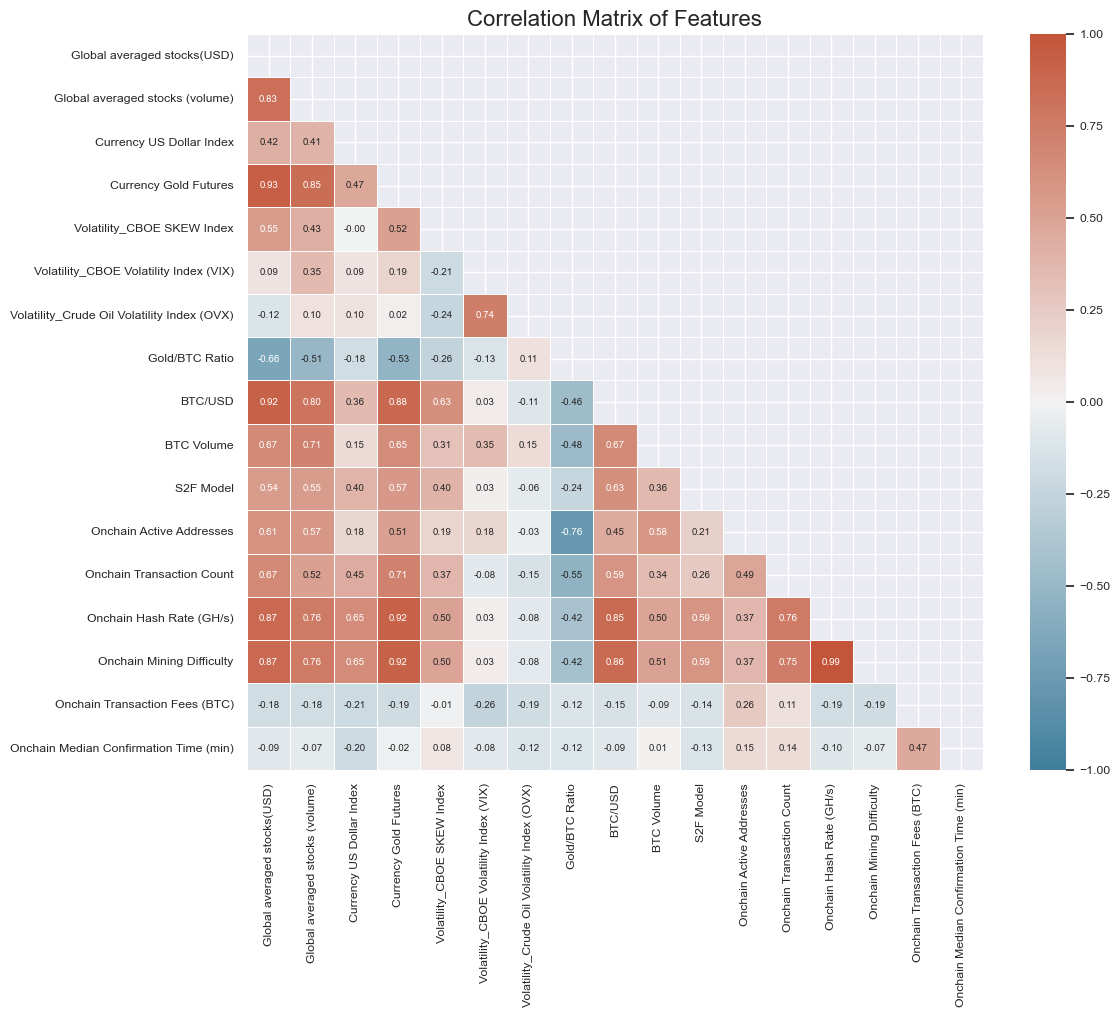

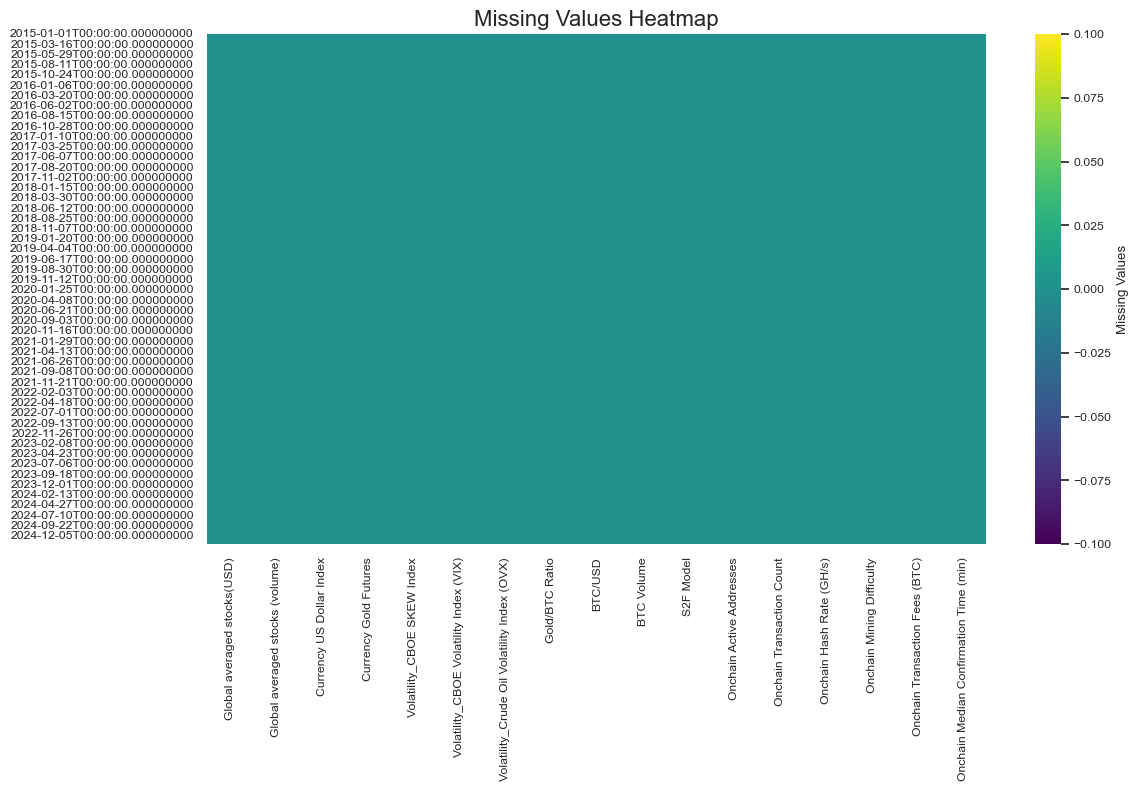

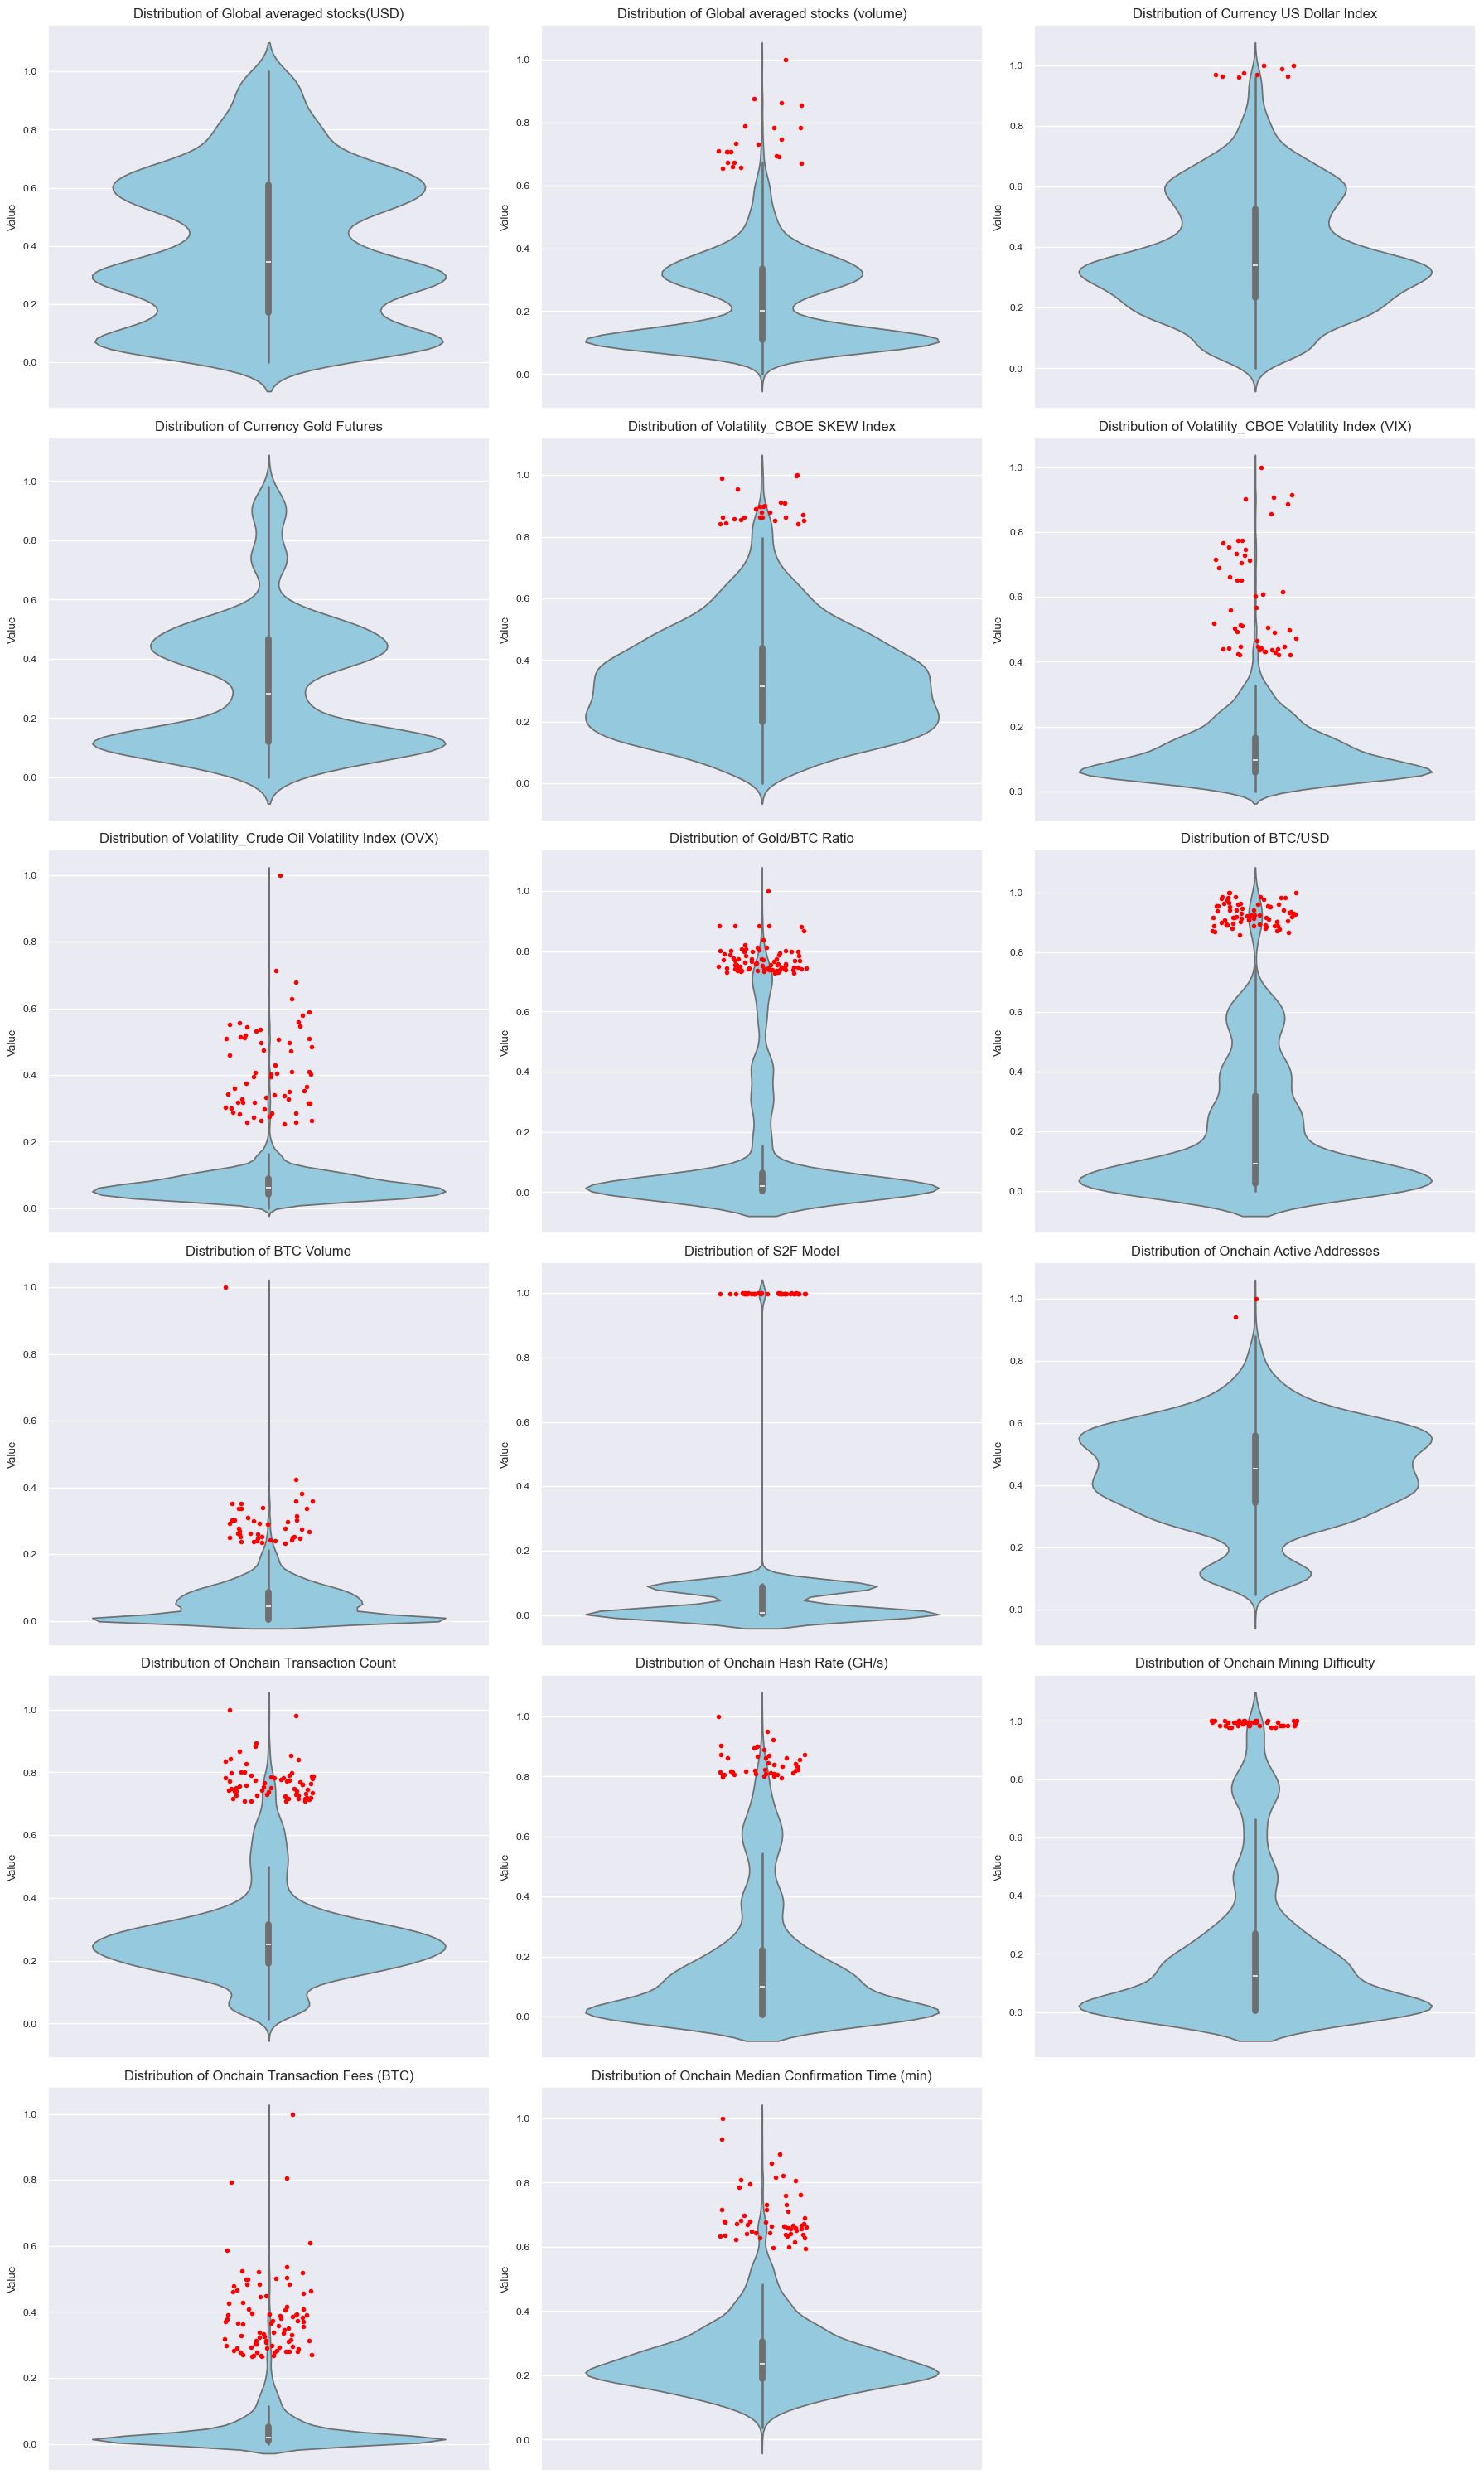

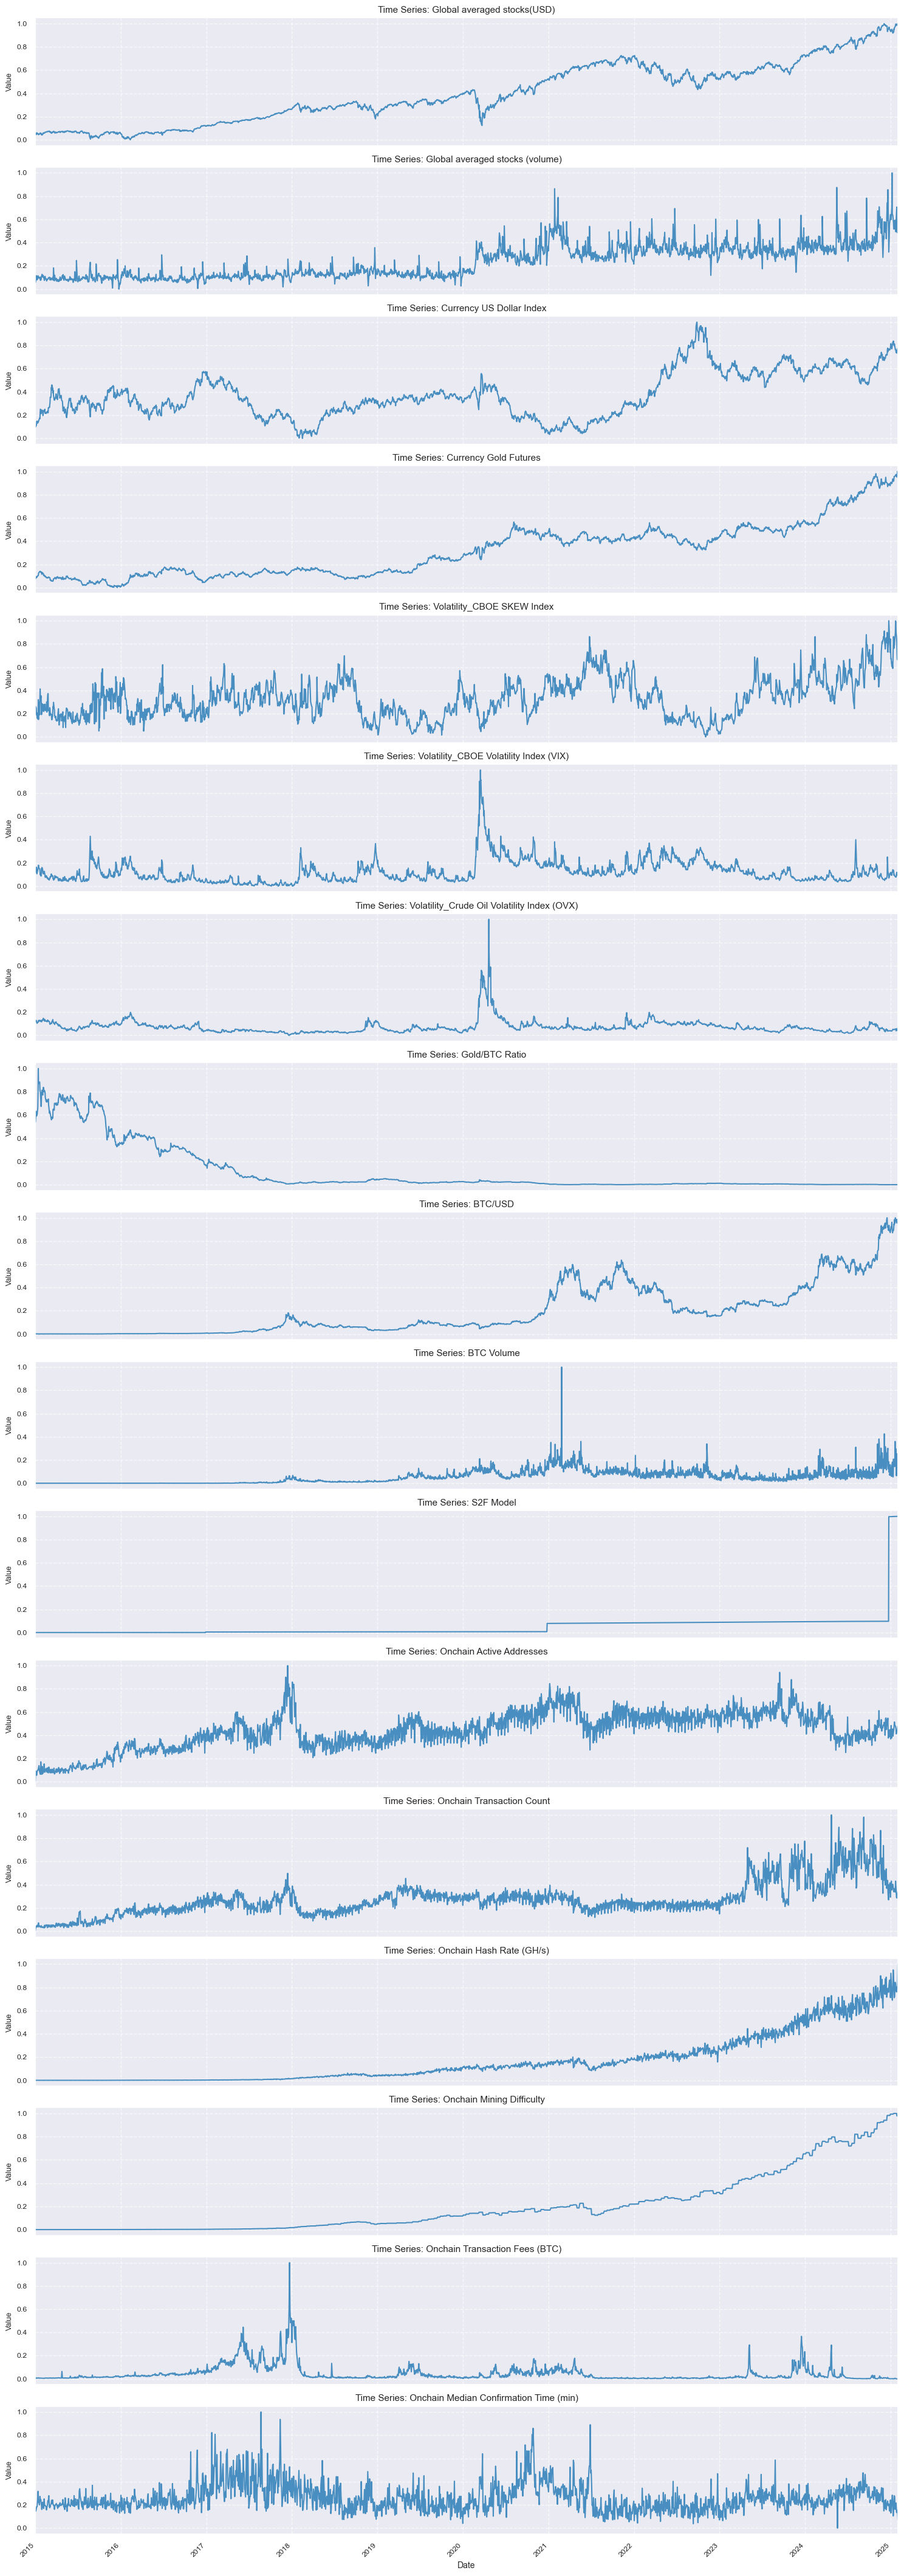

<Figure size 2000x2000 with 0 Axes>

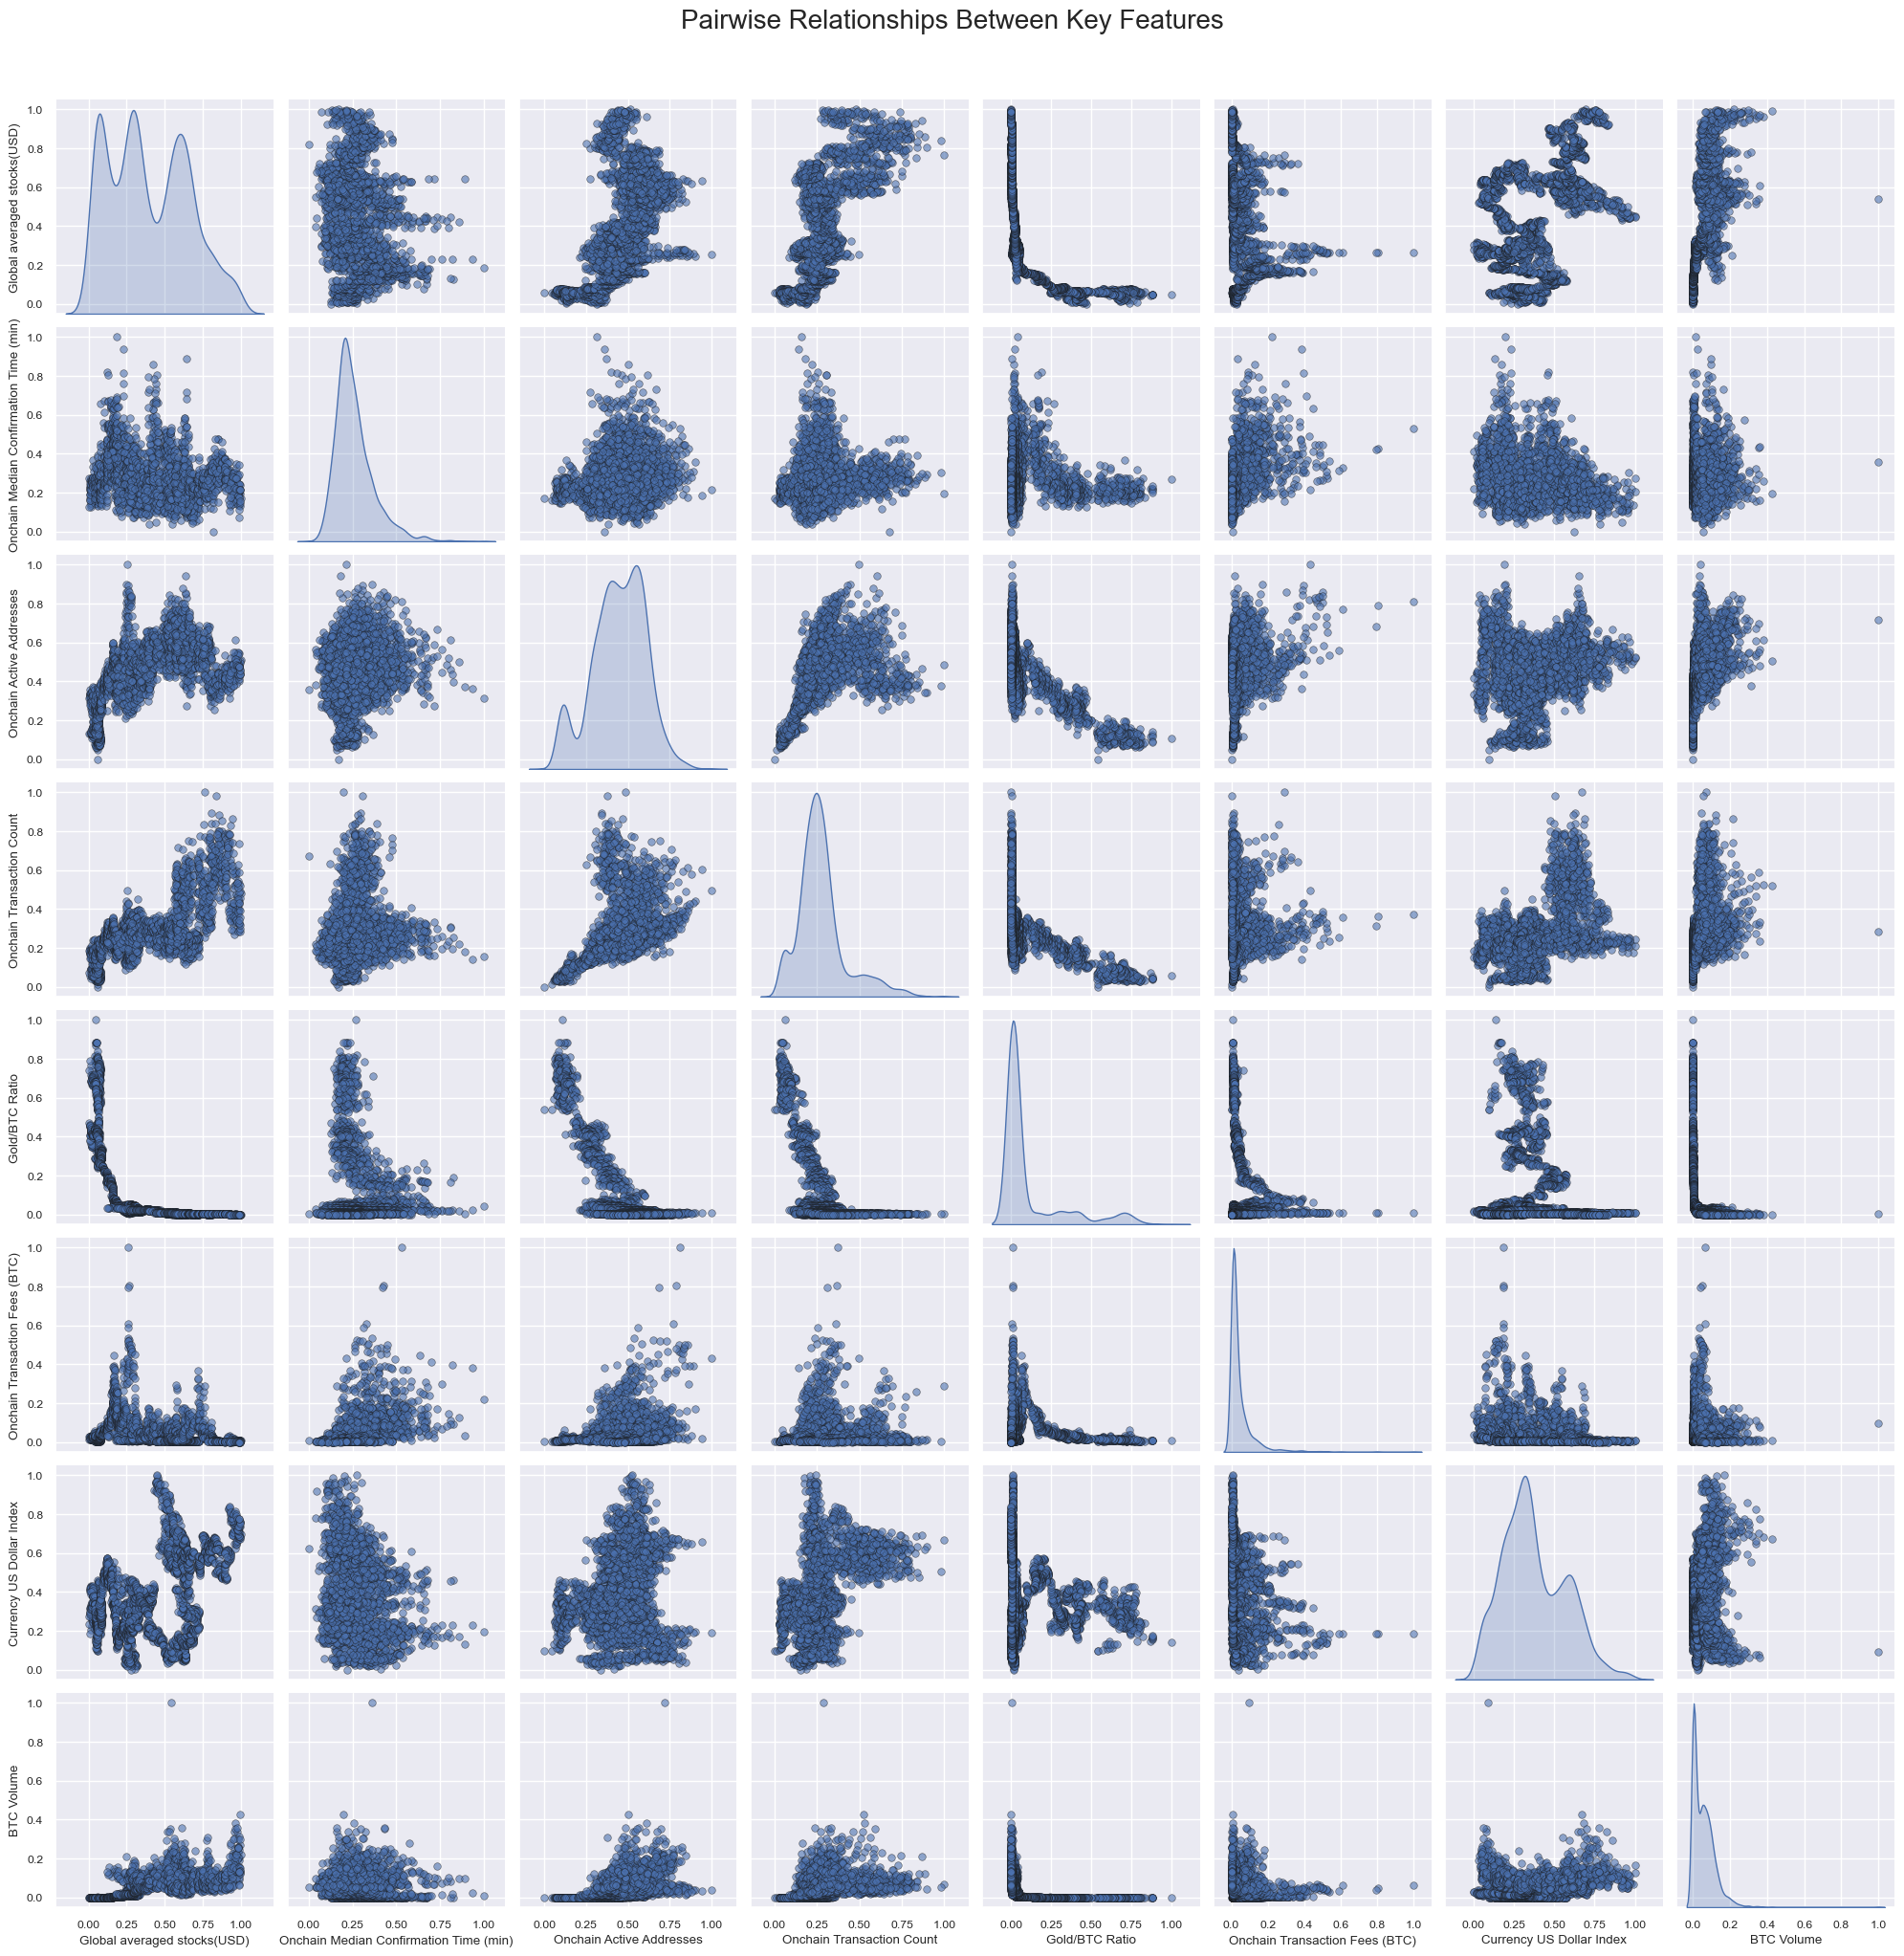

In [159]:
# Read the dataset
df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)

# 1. Correlation Matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.8)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.title('Correlation Matrix of Features', fontsize=16)
plt.tight_layout()
plt.savefig(output_dir / "charts" / "data_visualizations" / "correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Missing Value Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cmap='viridis', cbar_kws={'label': 'Missing Values'})
plt.title('Missing Values Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig(output_dir / "charts" / "data_visualizations" / "missing_values_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Distribution and Outliers - Box and Violin Plots
n_cols = len(df.columns)
n_rows = (n_cols + 2) // 3  # Arrange in rows of 3 plots

fig = plt.figure(figsize=(18, n_rows * 5))
gs = GridSpec(n_rows, 3, figure=fig)

for i, column in enumerate(df.columns):
    row, col = divmod(i, 3)
    ax = fig.add_subplot(gs[row, col])
    
    # Fix the warning by using color instead of palette
    sns.violinplot(y=df[column], ax=ax, inner='box', color='skyblue')
    ax.set_title(f'Distribution of {column}', fontsize=12)
    ax.set_ylabel('Value')
    
    # Add scatter points for outliers
    outliers = df[abs(df[column] - df[column].mean()) > (3 * df[column].std())]
    if not outliers.empty:
        sns.stripplot(y=outliers[column], ax=ax, color='red', size=4, jitter=True)

plt.tight_layout()
plt.savefig(output_dir / "charts" / "data_visualizations" / "distribution_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Time Series Plots - Using the common functions
fig, axes = plt.subplots(n_cols, 1, figsize=(15, n_cols * 2.5), sharex=True)

# Handle case where there's only one column
if n_cols == 1:
    axes = [axes]

for i, column in enumerate(df.columns):
    # Use the common plot_time_series function
    plot_time_series(df[column], f'Time Series: {column}', axes[i], 
                    color='#1f77b4', alpha=0.8, linewidth=1.5)
    
    # Use the common format_time_axis function
    format_time_axis(axes[i], is_last=(i == n_cols-1))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Use tight_layout with appropriate padding
plt.tight_layout(pad=1.2)
plt.savefig(output_dir / "charts" / "data_visualizations" / "time_series.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. BONUS: Combined Pairplot for selected features
if n_cols <= 10:  # Only do this if you have a reasonable number of columns
    plt.figure(figsize=(20, 20))
    sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'})
    plt.suptitle('Pairwise Relationships Between Features', y=1.02, fontsize=20)
    plt.tight_layout()
    plt.savefig(output_dir / "charts" / "data_visualizations" / "pairplot.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    # If too many columns, select a subset based on correlation
    # Get the most correlated features
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    
    # Keep correlated features and a few others
    important_cols = list(set(df.columns) - set(to_drop))
    if len(important_cols) > 8:
        important_cols = important_cols[:8]
    
    plt.figure(figsize=(20, 20))
    sns.pairplot(df[important_cols], diag_kind='kde', 
                plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'})
    plt.suptitle('Pairwise Relationships Between Key Features', y=1.02, fontsize=20)
    plt.tight_layout()
    plt.savefig(output_dir / "charts" / "data_visualizations" / "pairplot_selected.png", dpi=300, bbox_inches='tight')
    plt.show()

Instead of handling outliers by averaging or removing them, the choise was made to follow this case studies method of outlier handling instead (Gil et al., 2024) by utilizing "multiresolution wavelet reconstruction" or "denoising" on the dataset, the specific mathematical formula for this was not detailed in the case study followed however but was "inspired" or rather a modified techneque referenced from a different paper (Peng et al., 2021). For this project the later was chosen due to its more detailed descripting making it easier to replicated more accurately.

The following denoising code was block was largely assisted by deepseek-r1, based on (Peng et al., 2021)'s paper. (Deepseek-r1, 2025)

In [160]:
# Wavelet denoising function
def wavelet_denoising(df, wavelet='db4', level=3): # (Deepseek-r1, 2025)
    """
    Apply wavelet denoising to all columns in a DataFrame
    """
    df_denoised = df.copy()
    
    for column in df.columns:
        # 1. Multi-level decomposition
        coeffs = pywt.wavedec(df[column].values, wavelet, level=level)
        
        # 2. Calculate noise threshold
        sigma = mad(coeffs[-1])
        n = len(df[column])
        threshold = sigma * np.sqrt(2 * np.log(n)) * 0.8  # Conservative thresholding
        
        # 3. Apply soft thresholding
        coeffs_modified = [coeffs[0]]
        for i in range(1, len(coeffs)):
            coeffs_modified.append(pywt.threshold(coeffs[i], threshold, 'soft'))
        
        # 4. Reconstruct signal
        denoised_data = pywt.waverec(coeffs_modified, wavelet)
        
        # 5. Handle boundary effects
        if len(denoised_data) > len(df):
            denoised_data = denoised_data[:len(df)]
        elif len(denoised_data) < len(df):
            denoised_data = np.pad(denoised_data, (0, len(df)-len(denoised_data)), 'edge')
            
        df_denoised[column] = denoised_data
    
    return df_denoised

Plotting the results of the denoised data side by side with showing the noise data that wasremoved from the dataset. According to (Gil et al., 2024) the denoised data maintains many of its price structure characterists without as much "radnomness" or minor price action that would otherwise only serve to confuse the model.

In [161]:
def plot_denoising_results(original_data, denoised_data, column_name): # (Claude, 2025)
    """
    Plot denoising results with consistent styling matching the time series plots
    """
    noise = original_data[column_name] - denoised_data[column_name]
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Original and denoised data
    plot_time_series(original_data[column_name], f'Denoising Results for {column_name}', 
                    axes[0], color='#1f77b4', alpha=0.5, linewidth=1.5)
    plot_time_series(denoised_data[column_name], None, 
                    axes[0], color='#ff7f0e', alpha=0.8, linewidth=1.5)
    axes[0].legend(['Original', 'Denoised'], loc='upper right', fontsize=9)
    
    # Removed noise
    plot_time_series(noise, 'Removed Noise Component', 
                    axes[1], color='#d62728', alpha=0.5, linewidth=1)
    
    # Format time axis
    format_time_axis(axes[0], is_last=False)
    format_time_axis(axes[1], is_last=True)
    
    # Adjust spacing
    plt.subplots_adjust(hspace=0.2)
    plt.tight_layout(pad=1.2)
    
    return fig

# Print summary statistics
print("Dataset Summary Statistics:")
print(df.describe())

# Print missing value counts
print("\nMissing Values Count:")
print(df.isna().sum())
print(f"Total missing values: {df.isna().sum().sum()}")

Dataset Summary Statistics:
       Global averaged stocks(USD)  Global averaged stocks (volume)  \
count                  3685.000000                      3685.000000   
mean                      0.398174                         0.232904   
std                       0.257755                         0.140133   
min                       0.000000                         0.000000   
25%                       0.172168                         0.108442   
50%                       0.343978                         0.200793   
75%                       0.609959                         0.334357   
max                       1.000000                         1.000000   

       Currency US Dollar Index  Currency Gold Futures  \
count               3685.000000            3685.000000   
mean                   0.375293               0.317021   
std                    0.194996               0.228329   
min                    0.000000               0.000000   
25%                    0.232759           

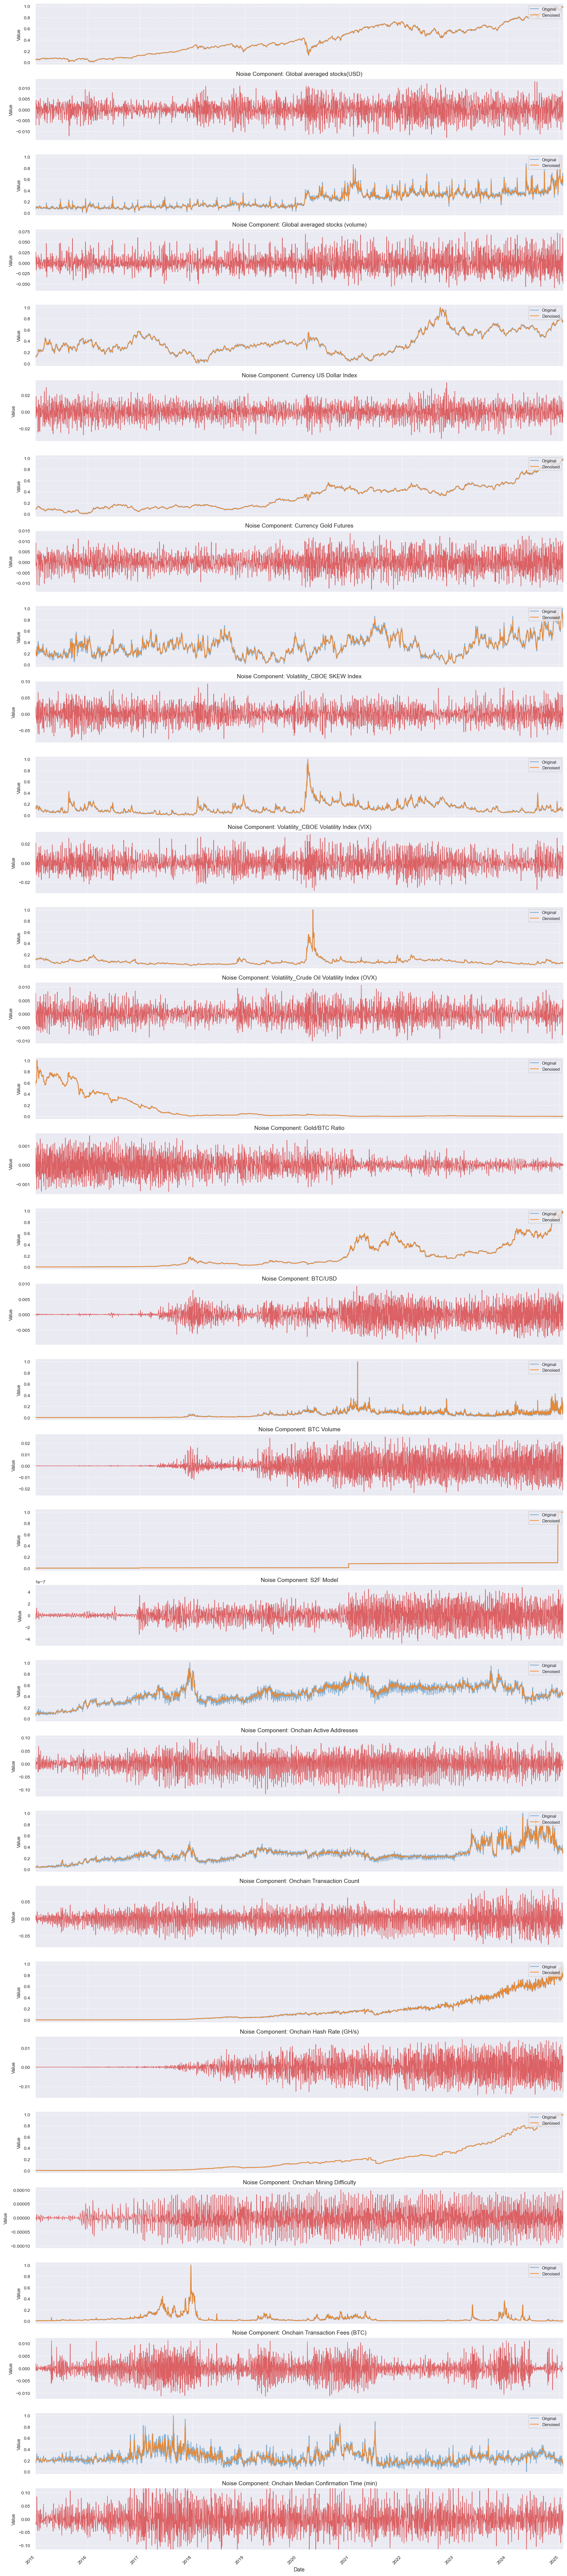

Denoised dataset saved to e:\Documents\skool work\Msc\AI module\Msc-COM7003-AI-Model\dataset\2015-2025_dataset_denoised.csv


In [162]:
def plot_all_denoised_columns(original_df, denoised_df): # (Claude, 2025)
    """
    Plot all columns in a single figure with consistent styling,
    including noise charts underneath each time series
    """
    n_cols = len(original_df.columns)
    # Create twice as many rows - one for the signal, one for the noise
    fig, axes = plt.subplots(n_cols * 2, 1, figsize=(15, n_cols * 4), sharex=True)
    
    # Handle case where there's only one column
    if n_cols == 1:
        axes = np.array([axes[0], axes[1]])
    
    for i, column in enumerate(original_df.columns):
        # Calculate the noise component
        noise = original_df[column] - denoised_df[column]
        
        # Index for the signal plot
        signal_idx = i * 2
        # Index for the noise plot
        noise_idx = i * 2 + 1
        
        # Plot original and denoised data on the signal plot
        plot_time_series(original_df[column], f'Time Series: {column}', 
                        axes[signal_idx], color='#1f77b4', alpha=0.5, linewidth=1.5)
        plot_time_series(denoised_df[column], None, 
                        axes[signal_idx], color='#ff7f0e', alpha=0.8, linewidth=1.5)
        axes[signal_idx].legend(['Original', 'Denoised'], loc='upper right', fontsize=8)
        
        # Plot noise component on the noise plot
        plot_time_series(noise, f'Noise Component: {column}', 
                        axes[noise_idx], color='#d62728', alpha=0.7, linewidth=1)
        
        # Format time axes
        format_time_axis(axes[signal_idx], is_last=False)
        format_time_axis(axes[noise_idx], is_last=(i == n_cols-1 and noise_idx == (n_cols*2)-1))
        
    # Filter out NaN and Inf values before calculating statistics
    valid_noise = noise.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(valid_noise) > 0:
        noise_std = valid_noise.std()
        noise_mean = valid_noise.mean()
        
        # Check if the calculated values are finite
        if np.isfinite(noise_std) and np.isfinite(noise_mean) and noise_std > 0:
            axes[noise_idx].set_ylim([noise_mean - 3*noise_std, noise_mean + 3*noise_std])
        else:
            # Use default limits if statistics are not valid
            axes[noise_idx].set_ylim([-1, 1])
    else:
        # Use default limits if no valid data
        axes[noise_idx].set_ylim([-1, 1])
    
    # Adjust spacing
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(pad=1.2)
    
    return fig

# Main execution code
df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)

# Apply wavelet denoising
df_denoised = wavelet_denoising(df)

# Plot individual denoising results for each column
for column in df.columns:
    fig = plot_denoising_results(df, df_denoised, column)
    plt.savefig(output_dir / "charts" / "denoising" /  f"denoising_{column.replace('/', '_')}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

# Plot all columns in a single figure with noise charts
fig = plot_all_denoised_columns(df, df_denoised)
plt.savefig(output_dir / "charts" / "denoising" /  "all_denoised_columns_with_noise.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the denoised dataset
df_denoised.to_csv(output_dir / "2015-2025_dataset_denoised.csv")
print(f"Denoised dataset saved to {output_dir / '2015-2025_dataset_denoised.csv'}")

Now for feature selection:

(Ghosh et al., 2022)'s Bourta selection library.

(Tyralis & Papacharalampous, 2017)'s method - "Variable Selection in Time Series Forecasting Using Random Forests", using both his prediction and feature selection method.

LASSO feature selection method: https://www.tandfonline.com/doi/epdf/10.1080/09540091.2023.2286188?needAccess=true



The code for this section was AI assisted, along with help to understand the underlying papers solutions, methods and processes both Claude sonnet and deepseek r-1 were consulted (Claude, 2025), (Deepseek-r1, 2025).

This next specific block generates the resulting feature importance scores the algorithms used to decide on the features to be selected once called.

In [163]:
# Saving and plotting the feature selection of choice: # (Claude, 2025), (Deepseek-r1, 2025)
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0, parse_dates=True)
    return df

# Use 'Score' column consistently - AI contributed:
def plot_feature_importance(scores_df, method_name):
    plt.figure(figsize=(12, 8))
    
    # Get selected features and their scores
    selected_scores = scores_df[scores_df['Selected']]
    score_col = 'Score' if 'Score' in selected_scores.columns else 'Importance'
    
    # Create horizontal bar plot
    plt.barh(range(len(selected_scores)), selected_scores[score_col])
    plt.yticks(range(len(selected_scores)), selected_scores['Feature'])
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title(f'Feature Importance Scores - {method_name}')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

def save_selected_features(df, selected_features, target, method_name):
    final_features = selected_features + [target]
    df_selected = df[final_features]
    output_path = output_dir / f"2015-2025_dataset_selected_features_{method_name}.csv"
    df_selected.to_csv(output_path)
    return df_selected.shape

(Tyralis & Papacharalampous, 2017)'s feature selection method:

In [164]:
def random_forrest_selection(df, target='BTC/USD', window_size=30, n_estimators=500, perform_tuning=False, n_iterations=10, n_jobs=-1): # (Claude, 2025)
    print(f"\nInitializing Random Forest feature selection...")
    print(f"Input DataFrame shape: {df.shape}")
    print(f"Target column: {target}")
    print(f"Window size: {window_size}")
    
    if df.empty:
        raise ValueError("Input DataFrame is empty")
    
    start_time = time.time()
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Store feature names for later use
    feature_names = X.columns.tolist()
    print(f"Number of features: {len(feature_names)}")
    
    # Calculate number of windows
    n_windows = len(X) - window_size
    print(f"Number of windows: {n_windows}")
    
    # Initialize importance matrix
    importance_matrix = np.zeros((n_windows, X.shape[1]))
    
    # Determine optimal RF parameters if tuning is requested
    if perform_tuning:
        print("\nPerforming Bayesian hyperparameter tuning...")
        
        # Import required libraries for Bayesian optimization
        from skopt import BayesSearchCV
        from skopt.space import Real, Integer, Categorical
        
        # Use a sample window for tuning
        sample_window = slice(0, min(window_size * 3, len(X)))
        X_sample = X.iloc[sample_window]
        y_sample = y.iloc[sample_window]
        
        # Define the hyperparameter search space
        param_space = {
            'n_estimators': Integer(10, 100),
            'max_depth': Integer(3, 20),
            'min_samples_split': Integer(2, 10),
            'min_samples_leaf': Integer(1, 5),
            'max_features': Categorical(['sqrt', 'log2', None]),
            'bootstrap': Categorical([True, False])
        }
        
        # Create base RF model
        base_rf = RandomForestRegressor(random_state=42, n_jobs=n_jobs)
        
        # Create BayesSearchCV object
        bayes_search = BayesSearchCV(
            base_rf,
            param_space,
            n_iter=n_iterations,
            cv=3,  # Use 3-fold cross-validation
            scoring='neg_mean_squared_error',
            n_jobs=n_jobs,
            verbose=1,
            random_state=42
        )
        
        # Fit the Bayesian search
        print("Starting Bayesian optimization...")
        bayes_search.fit(X_sample, y_sample)
        
        # Get the best parameters
        best_params = bayes_search.best_params_
        print(f"Best parameters found: {best_params}")
        
        # Create RF with best parameters
        rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=n_jobs)
    else:
        # Use default parameters
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_features='sqrt',
            random_state=42,
            n_jobs=n_jobs
        )
    
    # Function to process a single window
    def process_window(i):
        # Extract window data
        window_data = X.iloc[i:i + window_size]
        window_target = y.iloc[i:i + window_size]
        
        # Fit RF on window
        rf_local = clone(rf)  # Create a clone to avoid race conditions
        rf_local.fit(window_data, window_target)
        baseline_score = rf_local.score(window_data, window_target)
        
        # Calculate feature importances
        importances = np.zeros(X.shape[1])
        
        for j in range(X.shape[1]):
            X_perm = window_data.copy()
            X_perm.iloc[:,j] = np.random.permutation(X_perm.iloc[:,j])
            perm_score = rf_local.score(X_perm, window_target)
            importances[j] = baseline_score - perm_score
        
        return importances
    
    # Process windows in parallel
    print("\nProcessing windows in parallel...")
    
    # Process windows in parallel with progress bar
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_window)(i) for i in tqdm(range(n_windows), desc="Processing windows")
    )
    
    # Combine results
    importance_matrix = np.array(results)
    
    # Calculate mean importance across windows
    mean_importances = importance_matrix.mean(axis=0)
    
    # Apply quantile threshold (75th percentile)
    threshold = np.quantile(mean_importances, 0.75)
    selected_features = [feature_names[i] for i, imp in enumerate(mean_importances) if imp > threshold]
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Feature': feature_names,
        'Score': mean_importances,
        'Selected': mean_importances > threshold
    }).sort_values('Score', ascending=False)
    
    # Print summary
    end_time = time.time()
    print(f"\nFeature selection completed in {end_time - start_time:.2f} seconds")
    print(f"Selected {len(selected_features)} out of {len(feature_names)} features")
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    
    # Sort features by importance
    sorted_idx = np.argsort(mean_importances)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    
    plt.barh(pos, mean_importances[sorted_idx], align='center')
    plt.yticks(pos, np.array(feature_names)[sorted_idx])
    plt.xlabel('Mean Importance')
    plt.title('Feature Importances (Random Forest)')
    
    # Add a vertical line at the threshold
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold (75th percentile)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return selected_features, results_df

LASSO Method:

In [165]:
def lasso_feature_selection(df, target='BTC/USD', alpha='auto'): # (Claude, 2025)
    from sklearn.linear_model import LassoCV, Lasso
    from sklearn.preprocessing import StandardScaler
    
    # Prepare data
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal alpha if auto
    if alpha == 'auto':
        lasso_cv = LassoCV(cv=5, random_state=42)
        lasso_cv.fit(X_scaled, y)
        alpha = lasso_cv.alpha_
    
    # Fit LASSO
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_scaled, y)
    
    # Get selected features
    selected_features = X.columns[lasso.coef_ != 0].tolist()
    
    # Create importance scores
    importance_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': np.abs(lasso.coef_),
        'Selected': lasso.coef_ != 0
    }).sort_values('Score', ascending=False)
    
    print(f"\nSelected {len(selected_features)} features")
    print("\nTop features and weights:")
    print(importance_scores[importance_scores['Selected']].head())
    
    return selected_features, importance_scores

'"Boruta" is an "ensemble feature selection algorithm" using random forrest with feature importance measures for selection, (Ghosh et al., 2022) We used the existing scikit-learn implementation of the Boruta algorithm available at https://github.com/scikit-learn-contrib/boruta_py."' (Pabuccu & Barbu, 2023).

In [166]:
def boruta_selection(df, target='BTC/USD', max_iter=100, importance_threshold=0.01): # (Claude, 2025)    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    rf = RandomForestRegressor(
        n_jobs=-1,
        max_depth=7,
        n_estimators=250,
        random_state=42
    )
    
    boruta = BorutaPy(
        rf,
        n_estimators='auto',
        max_iter=max_iter,
        perc=98,
        alpha=0.001,
        two_step=True,
        verbose=0,
        random_state=42
    )
    
    with tqdm(total=1, desc="Running Boruta Selection") as pbar:
        boruta.fit(X.values, y.values)
        pbar.update(1)
    
    if hasattr(boruta, 'importance_history_'):
        feature_importance = boruta.importance_history_.mean(axis=0)[:X.shape[1]]
        scores = feature_importance / np.max(feature_importance)
        
        min_nonzero = np.min(feature_importance[feature_importance > 0])
        relative_scores = np.zeros_like(feature_importance)
        nonzero_mask = feature_importance > 0
        relative_scores[nonzero_mask] = 10 * (np.log1p(feature_importance[nonzero_mask]) - np.log1p(min_nonzero)) / (np.log1p(np.max(feature_importance)) - np.log1p(min_nonzero))
    else:
        scores = np.ones(len(X.columns))
        relative_scores = np.ones(len(X.columns))
        feature_importance = np.ones(len(X.columns))
    
    significant_features = scores >= importance_threshold
    
    importance_scores = pd.DataFrame({
        'Feature': X.columns,
        'Importance': scores.round(4),
        'Relative_Importance': relative_scores.round(2),
        'Raw_Score': feature_importance.round(6),
        'Selected': significant_features,
        'Score': scores.round(4)  # Add Score column for compatibility
    })
    
    importance_scores = importance_scores.sort_values('Importance', ascending=False)
    selected_features = importance_scores[importance_scores['Selected']]['Feature'].tolist()
    
    print(f"\nSelected {len(selected_features)} features")
    print("\nSelected features by importance:")
    print(importance_scores[importance_scores['Selected']].to_string(index=False))
    
    return selected_features, importance_scores

this is the function that runs all three of the automated feature selection methods:

In [167]:
def run_feature_selection(method_choice): # (Claude, 2025)
    df = pd.read_csv(output_dir / "2015-2025_dataset_denoised.csv", index_col=0, parse_dates=True)
    target = 'BTC/USD'
    
    methods = {
        'random_forrest': {
            'func': random_forrest_selection,
            'params': {'window_size': 30}
        },
        'lasso': {
            'func': lasso_feature_selection,
            'params': {}
        },
        'boruta': {
            'func': boruta_selection,
            'params': {}
        }
    }
    
    # Execute selected method
    if method_choice in ['random_forrest', 'lasso', 'boruta']:
        selected_features, importance_scores = methods[method_choice]['func'](
            df, target, **methods[method_choice]['params']
        )
        
        # Ensure consistent column naming
        if 'Importance' in importance_scores.columns:
            importance_scores['Score'] = importance_scores['Importance']
        
        # Save results and plot
        shape = save_selected_features(df, selected_features, target, method_choice)
        plot_feature_importance(importance_scores, method_choice)
        
        print(f"\nSelected {len(selected_features)} features using {method_choice.upper()} method")
        print("Features:", ', '.join(selected_features))
        print(f"Output shape: {shape}")

#run_feature_selection('random_forrest')
#run_feature_selection('lasso')
#run_feature_selection('boruta')

Next up is the model, 2 AI algorithms were chosem for this: 

1. Random forrest:
2. xLSTM-TS (Supervised Learning - Regression):

In [168]:
def use_random_forrest_model(df, target_col='BTC/USD', sequence_length=30, perform_tuning=False, n_iterations=25): # (Claude, 2025)
    print("\nInitializing random forrest model training...")
    
    if df.empty:
        raise ValueError("Input DataFrame is empty")
    
    # Print debug info
    print(f"Input DataFrame shape: {df.shape}")
    print(f"Target column: {target_col}")
    
    # Calculate split points
    total_rows = len(df)
    train_size = int(total_rows * 0.7)
    val_size = int(total_rows * 0.15)
    
    # Split maintaining temporal order
    train_df = df[:train_size]
    val_df = df[train_size:train_size + val_size]  # Add validation set for hyperparameter tuning
    test_df = df[train_size + val_size:]
    
    print(f"Train shape: {train_df.shape}, Validation shape: {val_df.shape}, Test shape: {test_df.shape}")
    
    # Store original test values for evaluation
    original_test_actuals = test_df[target_col].values
    
    # Store original training data for MASE calculation
    y_train_original = train_df[target_col].values
    
    # Scale data with MinMaxScaler as per Tyralis paper
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    # Get feature columns
    feature_columns = [col for col in df.columns if col != target_col]
    print(f"Number of feature columns: {len(feature_columns)}")
    print(f"Feature columns: {feature_columns[:5]}{'...' if len(feature_columns) > 5 else ''}")
    
    # Fit and transform training data
    X_train = pd.DataFrame(
        feature_scaler.fit_transform(train_df[feature_columns]),
        columns=feature_columns,
        index=train_df.index
    )
    y_train = pd.Series(
        target_scaler.fit_transform(train_df[[target_col]]).ravel(),
        index=train_df.index
    )
    
    # Transform test data
    X_test = pd.DataFrame(
        feature_scaler.transform(test_df[feature_columns]),
        columns=feature_columns,
        index=test_df.index
    )
    y_test = pd.Series(
        target_scaler.transform(test_df[[target_col]]).ravel(),
        index=test_df.index
    )
    
    # Transform validation data
    X_val = pd.DataFrame(
        feature_scaler.transform(val_df[feature_columns]),
        columns=feature_columns,
        index=val_df.index
    )
    y_val = pd.Series(
        target_scaler.transform(val_df[[target_col]]).ravel(),
        index=val_df.index
    )
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    
    # Create sequences for random forrest model
    print("\nCreating sequences...")
    
    def create_sequences_random_forrest(X, y, seq_length=10): # (Claude, 2025)
        """Create sequences for the Random Forest model"""
        X_seq, y_seq = [], []
        
        with tqdm(total=len(X) - seq_length, desc="Creating sequences") as pbar:
            for i in range(len(X) - seq_length):
                # Input sequence
                X_seq.append(X.iloc[i:i + seq_length].values)
                
                # Target value (single step ahead for random forrest model)
                y_seq.append(y.iloc[i + seq_length])
                
                pbar.update(1)
        
        return np.array(X_seq), np.array(y_seq)
    
    # Create sequences
    X_train_seq, y_train_seq = create_sequences_random_forrest(X_train, y_train, seq_length=sequence_length)
    X_test_seq, y_test_seq = create_sequences_random_forrest(X_test, y_test, seq_length=sequence_length)
    X_val_seq, y_val_seq = create_sequences_random_forrest(X_val, y_val, seq_length=sequence_length)
    
    print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
    print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")
    print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")
    
    # Reshape for RF input - RF expects 2D input
    n_samples_train = X_train_seq.shape[0]
    n_samples_test = X_test_seq.shape[0]
    n_samples_val = X_val_seq.shape[0]
    n_features_per_timestep = X_train_seq.shape[2] if len(X_train_seq.shape) > 2 else 1
    total_features = sequence_length * n_features_per_timestep
    
    # Flatten the 3D sequences to 2D for RF
    X_train_rf = X_train_seq.reshape(n_samples_train, -1)
    X_test_rf = X_test_seq.reshape(n_samples_test, -1)
    X_val_rf = X_val_seq.reshape(n_samples_val, -1)
    
    print(f"X_train_rf shape: {X_train_rf.shape}, y_train_seq shape: {y_train_seq.shape}")
    print(f"X_test_rf shape: {X_test_rf.shape}, y_test_seq shape: {y_test_seq.shape}")
    print(f"X_val_rf shape: {X_val_rf.shape}, y_val_seq shape: {y_val_seq.shape}")
    print(f"Total features after flattening: {X_train_rf.shape[1]}")
    
    # Initialize and train the model based on whether tuning is requested
    tuning_info = {"tuned": perform_tuning}
    
    if perform_tuning:
        # Import required libraries for Bayesian optimization
        from skopt import BayesSearchCV
        from skopt.space import Real, Integer, Categorical
        
        print("\nPerforming Bayesian hyperparameter tuning...")
        
        # Define the hyperparameter search space
        param_space = {
            'n_estimators': Integer(100, 1000),
            'max_depth': Integer(5, 30),
            'min_samples_split': Integer(2, 20),
            'min_samples_leaf': Integer(1, 10),
            'max_features': Categorical(['sqrt', 'log2', None]),
            'bootstrap': Categorical([True, False])
        }
        
        # Create base RF model
        base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
        
        # Create BayesSearchCV object
        bayes_search = BayesSearchCV(
            base_rf,
            param_space,
            n_iter=n_iterations,
            cv=3,  # Use 3-fold cross-validation
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        # Fit the Bayesian search
        print("Starting Bayesian optimization...")
        start_time = time.time()
        bayes_search.fit(X_train_rf, y_train_seq)
        end_time = time.time()
        tuning_time = end_time - start_time
        
        # Get the best parameters and model
        best_params = bayes_search.best_params_
        print(f"Best parameters found: {best_params}")
        print(f"Best score: {-bayes_search.best_score_:.4f} MSE")
        print(f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")
        
        # Store tuning information
        tuning_info["best_params"] = best_params
        tuning_info["tuning_time"] = tuning_time
        
        # Use the best model
        rf_model = bayes_search.best_estimator_
        print("Training final model with best parameters...")
        
    else:
        # Initialize Random Forest model with default parameters
        print("\nInitializing Random Forest model with default parameters...")
        rf_model = RandomForestRegressor(
            n_estimators=500,  # 500 trees as per paper
            max_features='sqrt',  # Default mtry value
            min_samples_split=2,
            min_samples_leaf=1,
            bootstrap=True,
            random_state=42,
            verbose=1,  # Add verbosity to see training progress
            n_jobs=-1  # Use all available cores
        )
    
    # Train the model with timing (if not already trained during tuning)
    if not perform_tuning:
        print("Training model...")
        start_time = time.time()
        rf_model.fit(X_train_rf, y_train_seq)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Model training completed in {training_time:.2f} seconds")
    
    # Check model properties
    print(f"Number of trees in the forest: {len(rf_model.estimators_)}")
    print(f"Feature importances: {rf_model.feature_importances_[:5]}...")
    
    # Generate predictions
    print("Generating predictions...")
    predictions = rf_model.predict(X_test_rf)
    
    # Calculate R² score on test data
    r2_score = rf_model.score(X_test_rf, y_test_seq)
    print(f"R² score on test data: {r2_score:.4f}")
    
    # Inverse transform predictions to original scale
    predictions_reshaped = predictions.reshape(-1, 1)
    try:
        predictions_original = target_scaler.inverse_transform(predictions_reshaped).flatten()
    except:
        # Handle case where predictions might need reshaping
        predictions_original = np.array([target_scaler.inverse_transform([[p]])[0][0] for p in predictions])
    
    # Calculate some basic error metrics
    mse = np.mean((predictions_original - original_test_actuals[sequence_length:sequence_length+len(predictions_original)])**2)
    mae = np.mean(np.abs(predictions_original - original_test_actuals[sequence_length:sequence_length+len(predictions_original)]))
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    
    # Ensure predictions and actuals are the same length
    min_length = min(len(predictions_original), len(original_test_actuals[sequence_length:]))
    predictions_final = predictions_original[:min_length]
    actuals_final = original_test_actuals[sequence_length:sequence_length+min_length]
    
    # Print sample of predictions vs actuals
    print("\nSample predictions vs actuals:")
    for i in range(min(5, len(predictions_final))):
        print(f"Prediction: {predictions_final[i]:.4f}, Actual: {actuals_final[i]:.4f}")
    
    return rf_model, predictions_final, actuals_final, y_train_original, tuning_info

In [169]:
def compare_random_forrest_models(df, target_col='BTC/USD', sequence_length=10, n_iterations=25): # (Claude, 2025)
    """
    Run both the base random forrest model and the tuned version, then compare their performance
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    # Run the base model
    print("Running base radnom forrest model...")
    base_model, base_preds, base_actuals, y_train, _ = use_random_forrest_model(
        df, 
        target_col=target_col, 
        sequence_length=sequence_length,
        perform_tuning=False
    )
    
    # Run the tuned model
    print("\n\nRunning random forrest model with Bayesian hyperparameter tuning...")
    tuned_model, tuned_preds, tuned_actuals, _, tuning_info = use_random_forrest_model(
        df, 
        target_col=target_col, 
        sequence_length=sequence_length,
        perform_tuning=True,
        n_iterations=n_iterations
    )
    
    # Calculate error metrics
    base_mse = mean_squared_error(base_actuals, base_preds)
    base_mae = mean_absolute_error(base_actuals, base_preds)
    
    tuned_mse = mean_squared_error(tuned_actuals, tuned_preds)
    tuned_mae = mean_absolute_error(tuned_actuals, tuned_preds)
    
    # Calculate MASE for both models
    # MASE = MAE / MAE of naive forecast
    # For naive forecast, we use the previous value as the prediction
    naive_errors = np.abs(np.diff(y_train))
    naive_mae = np.mean(naive_errors)
    
    base_mase = base_mae / naive_mae
    tuned_mase = tuned_mae / naive_mae
    
    # Print comparison
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    print(f"{'Metric':<15} {'Base Model':<15} {'Tuned Model':<15} {'Improvement %':<15}")
    print("-"*60)
    print(f"{'MSE':<15} {base_mse:<15.4f} {tuned_mse:<15.4f} {(1 - tuned_mse/base_mse)*100:<15.2f}")
    print(f"{'MAE':<15} {base_mae:<15.4f} {tuned_mae:<15.4f} {(1 - tuned_mae/base_mae)*100:<15.2f}")
    print(f"{'MASE':<15} {base_mase:<15.4f} {tuned_mase:<15.4f} {(1 - tuned_mase/base_mase)*100:<15.2f}")
    print("="*50)
    
    if tuning_info["tuned"]:
        print("\nBest hyperparameters found:")
        for param, value in tuning_info["best_params"].items():
            print(f"  {param}: {value}")
    
    # Create a bar chart comparing MASE scores
    plt.figure(figsize=(10, 6))
    models = ['random forrest (Base)', 'random forrest (Tuned)']
    mase_scores = [base_mase, tuned_mase]
    
    bars = plt.bar(models, mase_scores, color=['orange', 'green'])
    
    # Add a horizontal line at MASE = 1
    plt.axhline(y=1, color='red', linestyle='--', label='MASE = 1 (Naive forecast)')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')
    
    plt.title('MASE Comparison: Base vs Tuned random forrest Model')
    plt.ylabel('MASE Score (lower is better)')
    plt.ylim(0, max(mase_scores) * 1.2)  # Add some space for labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add explanatory text
    plt.figtext(0.5, 0.01, 'MASE < 1: Model outperforms naive forecast\nMASE > 1: Naive forecast outperforms model', 
                ha='center', fontsize=10, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    plt.show()
    
    return {
        'base_model': base_model,
        'tuned_model': tuned_model,
        'base_metrics': {'MSE': base_mse, 'MAE': base_mae, 'MASE': base_mase},
        'tuned_metrics': {'MSE': tuned_mse, 'MAE': tuned_mae, 'MASE': tuned_mase},
        'tuning_info': tuning_info
    }

xLSTM-TS model:

In [170]:
def directional_loss(y_true, y_pred): # (Claude, 2025)
    """
    Custom loss function combining MSE and directional accuracy as per paper
    """
    # MSE component
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Directional component
    # Get directional movement (up/down) for true and predicted values
    y_true_direction = tf.cast(y_true[:, 1:] > y_true[:, :-1], tf.float32)
    y_pred_direction = tf.cast(y_pred[:, 1:] > y_pred[:, :-1], tf.float32)
    
    # Binary cross-entropy for directional accuracy
    directional = tf.reduce_mean(tf.keras.losses.binary_crossentropy(
        y_true_direction, 
        y_pred_direction,
        from_logits=False
    ))
    
    # Combine losses with weighting (α=0.7 as per paper)
    alpha = 0.7
    return alpha * mse + (1 - alpha) * directional

In [171]:
def create_sLSTM_block(inputs, embedding_dim=64, kernel_size=2, num_heads=2, ff_factor=1.1): # (Claude, 2025)
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    
    # Scalar memory LSTM with convolutional processing
    # Simulate sLSTM behavior using Conv1D + LSTM with different configuration
    conv = Conv1D(filters=embedding_dim, kernel_size=kernel_size, padding='same')(x)
    lstm = LSTM(embedding_dim, return_sequences=True, recurrent_activation='sigmoid')(conv)
    
    # Multi-head attention mechanism
    attention = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim // num_heads,
        value_dim=embedding_dim // num_heads
    )(lstm, lstm, lstm)
    
    # Feedforward network with projection factor
    ff_dim = int(embedding_dim * ff_factor)
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dense(embedding_dim)(ff)
    
    # Residual connection
    output = Add()([inputs, ff])
    
    return output

def create_mLSTM_block(inputs, embedding_dim=64, kernel_size=4, projection_size=2, num_heads=2): # (Claude, 2025)
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    
    # Matrix memory LSTM with convolutional processing
    # Simulate mLSTM behavior using Conv1D + LSTM
    conv = Conv1D(filters=embedding_dim, kernel_size=kernel_size, padding='same')(x)
    lstm = LSTM(embedding_dim, return_sequences=True)(conv)
    
    # Multi-head attention mechanism
    attention = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim // num_heads,
        value_dim=embedding_dim // num_heads
    )(lstm, lstm, lstm)
    
    # Projection to match dimensions
    projection = Dense(embedding_dim * projection_size)(attention)
    projection = Dense(embedding_dim)(projection)  # Project back to embedding_dim
    
    # Residual connection
    output = Add()([inputs, projection])
    
    return output

In [172]:
def create_xLSTM_TS_model(input_shape, embedding_dim=64, output_size=7): # (Claude, 2025)
    inputs = Input(shape=input_shape)
    
    # Initial linear projection to embedding dimension
    x = Dense(embedding_dim)(inputs)
    
    # xLSTM block stack as per Table IV in the paper
    # mLSTM block 1
    x = create_mLSTM_block(
        x, 
        embedding_dim=embedding_dim,
        kernel_size=4,
        projection_size=2,
        num_heads=2
    )
    
    # sLSTM block
    x = create_sLSTM_block(
        x, 
        embedding_dim=embedding_dim,
        kernel_size=2,
        num_heads=2,
        ff_factor=1.1
    )
    
    # mLSTM block 2
    x = create_mLSTM_block(
        x, 
        embedding_dim=embedding_dim,
        kernel_size=4,
        projection_size=2,
        num_heads=2
    )
    
    # mLSTM block 3
    x = create_mLSTM_block(
        x, 
        embedding_dim=embedding_dim,
        kernel_size=4,
        projection_size=2,
        num_heads=2
    )
    
    # Final layer normalization
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling to reduce sequence dimension
    x = GlobalAveragePooling1D()(x)
    
    # Final linear projection to output size
    outputs = Dense(output_size)(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [173]:
def create_sequences_random_forrest(data, sequence_length=10, forecast_horizon=1, progress_bar=True): # (Claude, 2025)
    if isinstance(data, pd.Series):
        # Convert Series to DataFrame for consistent handling
        data = data.to_frame()
    
    n_samples = len(data) - sequence_length - forecast_horizon + 1
    n_features = data.shape[1]
    
    # Initialize empty arrays
    X = np.zeros((n_samples, sequence_length, n_features))
    y = np.zeros((n_samples,))
    
    # Create progress bar if requested
    if progress_bar:
        iterator = tqdm(range(n_samples), desc="Creating sequences")
    else:
        iterator = range(n_samples)
    
    # Create sequences
    for i in iterator:
        # Input sequence (lookback window)
        X[i] = data.iloc[i:i+sequence_length].values
        
        # Target value (single step ahead as per Tyralis paper)
        y[i] = data.iloc[i+sequence_length].values[0]  # Take first column if multiple features
    
    return X, y

In [174]:
class TrainingProgressCallback(tf.keras.callbacks.Callback): # (Claude, 2025)
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.steps = self.params['steps'] * self.epochs
        self.progress_bar = tqdm(
            total=self.steps,
            desc="Training Progress",
            unit="batch",
            leave=True  # Ensure progress bar remains after completion
        )
        self.current_step = 0
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0
    
    def on_batch_end(self, batch, logs=None): # (Claude, 2025)
        self.current_step += 1
        self.progress_bar.update(1)
        
        # Update progress bar with more detailed metrics
        self.progress_bar.set_postfix({
            'loss': f"{logs['loss']:.4f}",
            'val_loss': f"{logs.get('val_loss', 'N/A')}",
            'mae': f"{logs['mae']:.4f}",
            'epoch': f"{self.current_step // self.params['steps']}/{self.epochs}"
        })
    
    def on_epoch_end(self, epoch, logs=None): # (Claude, 2025)
        # Monitor validation loss for early stopping
        current_loss = logs.get('val_loss', logs['loss'])
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            
        # Update progress bar with epoch information
        self.progress_bar.set_postfix({
            'loss': f"{logs['loss']:.4f}",
            'val_loss': f"{logs.get('val_loss', 'N/A')}",
            'mae': f"{logs['mae']:.4f}",
            'epoch': f"{epoch + 1}/{self.epochs}",
            'no_improve': self.epochs_without_improvement
        })
    
    def on_train_end(self, logs=None): # (Claude, 2025)
        self.progress_bar.close()

In [182]:
def use_xLSTM_TS_model(df, target_col='BTC/USD', sequence_length=150): # sequence length 150 # (Claude, 2025)
    print("\nInitializing xLSTM-TS model training...")
    
    if df.empty:
        raise ValueError("Input DataFrame is empty")
    
    # Print debug info
    print(f"Input DataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Check if we have enough features
    if len(df.columns) <= 1:
        # Create a simple feature from the target (e.g., previous value)
        df['prev_price'] = df[target_col].shift(1)
        df = df.dropna()  # Remove the first row which will have NaN
        print("Added previous price as a feature")
    
    # Calculate split points
    total_rows = len(df)
    train_size = int(total_rows * 0.7)
    val_size = int(total_rows * 0.15)
    
    # Split maintaining temporal order
    train_df = df[:train_size]
    val_df = df[train_size:train_size + val_size]
    test_df = df[train_size + val_size:]
    
    print(f"Train shape: {train_df.shape}")
    
    # Store original test values
    original_test_actuals = test_df[target_col].values
    
    # Scale data with proper DataFrame handling
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    # Get feature columns
    feature_columns = [col for col in df.columns if col != target_col]
    print(f"Feature columns: {feature_columns}")
    
    # Fit and transform training data
    X_train = pd.DataFrame(
        feature_scaler.fit_transform(train_df[feature_columns]),
        columns=feature_columns,
        index=train_df.index
    )
    y_train = pd.Series(
        target_scaler.fit_transform(train_df[[target_col]]).ravel(),
        index=train_df.index
    )
    
    # Transform validation data
    X_val = pd.DataFrame(
        feature_scaler.transform(val_df[feature_columns]),
        columns=feature_columns,
        index=val_df.index
    )
    y_val = pd.Series(
        target_scaler.transform(val_df[[target_col]]).ravel(),
        index=val_df.index
    )
    
    # Transform test data
    X_test = pd.DataFrame(
        feature_scaler.transform(test_df[feature_columns]),
        columns=feature_columns,
        index=test_df.index
    )
    y_test = pd.Series(
        target_scaler.transform(test_df[[target_col]]).ravel(),
        index=test_df.index
    )
    
    # Store original training data for MASE calculation
    y_train_original = train_df[target_col].values
    
    # Create sequences
    print("\nCreating sequences...")
    sequence_progress = tqdm(total=3, desc="Sequence preparation")
    
    # Training sequences - using sequence_length=150 as per paper
    X_seq, y_seq = [], []
    for i in range(len(X_train) - sequence_length - 6):
        X_seq.append(X_train.iloc[i:i + sequence_length].values)
        y_seq.append(y_train.iloc[i + sequence_length:i + sequence_length + 7].values.reshape(-1))
    X_train_seq, y_train_seq = np.array(X_seq), np.array(y_seq)
    sequence_progress.update(1)
    
    # Validation sequences
    X_seq, y_seq = [], []
    for i in range(len(X_val) - sequence_length - 6):
        X_seq.append(X_val.iloc[i:i + sequence_length].values)
        y_seq.append(y_val.iloc[i + sequence_length:i + sequence_length + 7].values.reshape(-1))
    X_val_seq, y_val_seq = np.array(X_seq), np.array(y_seq)
    sequence_progress.update(1)
    
    # Test sequences
    X_seq, y_seq = [], []
    for i in range(len(X_test) - sequence_length - 6):
        X_seq.append(X_test.iloc[i:i + sequence_length].values)
        y_seq.append(y_test.iloc[i + sequence_length:i + sequence_length + 7].values.reshape(-1))
    X_test_seq, y_test_seq = np.array(X_seq), np.array(y_seq)
    sequence_progress.update(1)
    sequence_progress.close()
    
    # Get number of features (excluding target column)
    n_features = X_train.shape[1]  # Number of features after dropping target column
    
    # Initialize model with the paper's xLSTM-TS architecture
    print("\nInitializing model...")
    
    # Create the model using our new implementation
    model = create_xLSTM_TS_model(
        input_shape=(sequence_length, n_features),
        embedding_dim=64,  # As per paper
        output_size=7      # 7-day forecast
    )
    
    # Configure optimizer with paper's parameters
    optimizer = Adam(
        learning_rate=1e-4,  # As per paper
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Compile model with directional loss
    model.compile(
        optimizer=optimizer,
        loss=directional_loss,
        metrics=['mae']
    )
    
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=30,  # As per paper
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,  # As per paper
            min_lr=1e-6
        ),
        TrainingProgressCallback()
    ]
    
    print("\nTraining model...")
    # Train model with paper's parameters
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=200,         # 200 As per paper
        batch_size=16,      # As per paper
        callbacks=callbacks,
        verbose=0,          # Disable default verbose output to use custom progress bar
        shuffle=False
    )
    
    return model, history, (X_test_seq, y_test_seq), target_scaler, y_train_original, original_test_actuals

In [176]:
def plot_metrics(metrics, model_choice=None, predictions=None, actuals=None, output_dir=None): # (Claude, 2025)
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Model Performance Metrics: {model_choice}', fontsize=16)
    
    # Flatten the axes for easier indexing
    axs = axs.flatten()
    
    # Plot 1: Classification Metrics (top left)
    classification_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = []
    
    # Extract values from metrics dictionary
    for metric in classification_metrics:
        if metric in metrics:
            values.append(float(metrics[metric]))
        else:
            values.append(0)
    
    create_bar_plot(
        axs[0], 
        classification_metrics, 
        values, 
        'Classification Metrics', 
        'Score', 
        color='#1f77b4', 
        percentage=True
    )
    axs[0].set_ylim(0, 1)
    
    # Plot 2: Regression Metrics (top right)
    regression_metrics = ['MAE', 'RMSE']
    values = []
    
    # Extract values from metrics dictionary
    for metric in regression_metrics:
        if metric in metrics:
            values.append(float(metrics[metric]))
        else:
            values.append(0)
    
    create_bar_plot(
        axs[1], 
        regression_metrics, 
        values, 
        'Regression Metrics', 
        'Error Rate', 
        color='#2ca02c', 
        percentage=True
    )
    
    # Plot 3: Predictions vs Actuals (bottom left)
    if predictions is not None and actuals is not None and len(predictions) > 0 and len(actuals) > 0:
        # Plot a sample of predictions vs actuals
        sample_size = min(100, len(predictions))
        indices = np.arange(sample_size)
        
        # Ensure we have enough data
        if len(actuals) >= sample_size and len(predictions) >= sample_size:
            plot_time_series_comparison(
                indices,
                actuals[:sample_size],
                predictions[:sample_size],
                'Predictions vs Actuals (Sample)',
                axs[2],
                labels=['Actual', 'Predicted']
            )
        else:
            axs[2].text(0.5, 0.5, 'Insufficient data for plotting', 
                    ha='center', va='center', transform=axs[2].transAxes)
    else:
        axs[2].text(0.5, 0.5, 'No prediction data available', 
                ha='center', va='center', transform=axs[2].transAxes)
        axs[2].set_title('Predictions vs Actuals', fontsize=11)
    
    # Plot 4: RMSSE and MASE Metrics (bottom right)
    additional_metrics = []
    values = []
    
    if 'RMSSE' in metrics and metrics['RMSSE'] is not None:
        try:
            additional_metrics.append('RMSSE')
            values.append(float(metrics['RMSSE']))
        except (ValueError, TypeError):
            pass
    
    if 'MASE' in metrics and metrics['MASE'] is not None:
        try:
            additional_metrics.append('MASE')
            values.append(float(metrics['MASE']))
        except (ValueError, TypeError):
            pass
    
    if additional_metrics and values:
        create_bar_plot(
            axs[3], 
            additional_metrics, 
            values, 
            'Time Series Specific Metrics', 
            'Score', 
            color='#ff7f0e', 
            percentage=False
        )
    else:
        axs[3].text(0.5, 0.5, 'Time series metrics not available', 
                ha='center', va='center', transform=axs[3].transAxes)
        axs[3].set_title('Time Series Specific Metrics', fontsize=11)
    
    # Adjust spacing and layout
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    if output_dir:
        plt.savefig(output_dir / f'{model_choice}_metrics.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
def print_metrics(metrics, model_name): # (Claude, 2025)
    """
    Print formatted metrics
    """
    print(f"\n{model_name} Model Results:")
    print("-" * 40)
    
    # Classification metrics as percentages
    print("\nClassification Metrics:")
    for metric in ['Accuracy', 'Recall', 'Precision', 'F1 Score']:
        if metric in metrics:
            print(f"{metric:15s}: {metrics[metric]*100:6.2f}%")
    
    # Regression metrics
    print("\nRegression Metrics:")
    for metric in ['MAE', 'RMSE']:
        if metric in metrics:
            print(f"{metric:15s}: {metrics[metric]*100:6.2f}%")
    
    # Time series specific metrics
    print("\nTime Series Metrics:")
    for metric in ['MASE', 'RMSSE']:
        if metric in metrics:
            print(f"{metric:15s}: {metrics[metric]:6.4f}")

In [177]:
def evaluate_model(predictions, actuals, y_train): # (Claude, 2025)
    """
    Calculate evaluation metrics on the raw predictions without modifications
    """
    # Input validation and reshaping only (no value modifications)
    predictions = np.array(predictions).reshape(-1)
    actuals = np.array(actuals).reshape(-1)
    y_train = np.array(y_train).reshape(-1)
    
    # Calculate directional changes
    binary_pred = np.diff(predictions) > 0
    binary_true = np.diff(actuals) > 0
    
    # Calculate classification metrics
    try:
        accuracy = accuracy_score(binary_true, binary_pred)
        recall = recall_score(binary_true, binary_pred)
        precision = precision_score(binary_true, binary_pred)
        f1 = f1_score(binary_true, binary_pred)
    except Exception as e:
        print(f"Warning: Classification metrics calculation failed: {e}")
        accuracy = recall = precision = f1 = 0.0
    
    # Calculate error metrics on the raw values
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mase = calculate_mase(actuals, predictions, y_train)
    rmsse = calculate_rmsse(actuals, predictions, y_train)
    
    return {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'MAE': mae,
        'RMSE': rmse,
        'MASE': mase,
        'RMSSE': rmsse
    }

def calculate_mase(y_true, y_pred, y_train): # (Claude, 2025)
    """
    Calculate Mean Absolute Scaled Error with validation
    """
    mae = mean_absolute_error(y_true, y_pred)
    
    # Calculate naive forecast error (t+1 = t)
    naive_errors = y_train[1:] - y_train[:-1]
    naive_error = np.mean(np.abs(naive_errors))
    
    # Avoid division by zero
    if naive_error == 0 or np.isnan(naive_error):
        print("Warning: Naive error is zero or NaN, using MAE instead")
        return mae
    
    return mae / naive_error

def calculate_rmsse(y_true, y_pred, y_train): # (Claude, 2025)
    """
    Calculate Root Mean Squared Scaled Error with validation
    """
    mse = mean_squared_error(y_true, y_pred)
    
    # Calculate naive forecast error
    naive_errors = (y_train[1:] - y_train[:-1])**2
    naive_error = np.mean(naive_errors)
    
    # Avoid division by zero
    if naive_error == 0 or np.isnan(naive_error):
        print("Warning: Naive error is zero or NaN, using RMSE instead")
        return np.sqrt(mse)
    
    return np.sqrt(mse / naive_error)

In [178]:
def get_predictions(model_results, model_choice): # (Claude, 2025)
    print("\nGenerating predictions...")
    
    if model_choice == 'xLSTM_TS':
        model, _, test_data, scaler, y_train_original, original_test_actuals = model_results
        X_test, y_test = test_data
        
        # Generate predictions
        raw_predictions = model.predict(X_test)
        predictions = raw_predictions[:, 0]  # Take first day predictions
        
        # Validation checks
        if np.any(np.isnan(predictions)):
            print("Warning: NaN values detected in predictions")
            predictions = np.nan_to_num(predictions, 0)
        
        # Debug information
        print("\nPrediction Scaling Check:")
        print(f"Raw predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
        
        # Reshape and inverse transform
        predictions = predictions.reshape(-1, 1)
        predictions = scaler.inverse_transform(predictions).flatten()
        
        print(f"Inverse transformed range: [{predictions.min():.4f}, {predictions.max():.4f}]")
        print(f"Expected range (actuals): [{original_test_actuals.min():.4f}, {original_test_actuals.max():.4f}]")
        
        # Ensure same length
        min_length = min(len(predictions), len(original_test_actuals))
        predictions = predictions[:min_length]
        original_test_actuals = original_test_actuals[:min_length]
        
        return predictions, original_test_actuals, y_train_original
    else:
        model, predictions, actuals, y_train = model_results
        return predictions, actuals, y_train
        
def evaluate_and_save_results(predictions, actuals, y_train, model_choice, output_dir): # (Claude, 2025)
    """
    Evaluate model performance and save results
    """
    print("\nStarting evaluation...")
    print(f"Initial shapes - Predictions: {predictions.shape}, Actuals: {actuals.shape}, y_train: {y_train.shape}")
    
    # Calculate metrics
    metrics = evaluate_model(predictions, actuals, y_train, model_choice)
    
    # Print metrics
    print_metrics(metrics, model_choice)
    
    # Plot results
    fig = plot_metrics(metrics, model_choice, predictions, actuals)
    
    # Save metrics to CSV
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(output_dir / f'{model_choice}_model_metrics.csv', index=False)
    
    # Save plot
    fig.savefig(output_dir / f'{model_choice}_metrics_plot.png', dpi=300, bbox_inches='tight')
    
    return metrics

In [179]:
def plot_mase_comparison(all_results, output_dir=None): # (Claude, 2025)
    # Extract dataset names and model types
    datasets = list(all_results.keys())
    
    # Prepare data for plotting
    labels = []
    mase_values = []
    colors = []
    
    # Define consistent colors for models
    model_colors = {
        'xLSTM_TS': '#1f77b4',    # Blue
        'random_forrest': '#2ca02c',  # Green
        'default': '#ff7f0e'   # Orange (for any other models)
    }
    
    for dataset in datasets:
        for model in all_results[dataset]:
            if 'MASE' in all_results[dataset][model] and all_results[dataset][model]['MASE'] is not None:
                try:
                    mase_value = float(all_results[dataset][model]['MASE'])
                    
                    labels.append(f"{dataset}\n({model})")
                    mase_values.append(mase_value)
                    
                    # Assign color based on model type
                    if model.lower() in model_colors:
                        colors.append(model_colors[model.lower()])
                    else:
                        colors.append(model_colors['default'])
                        
                except (ValueError, TypeError):
                    continue
    
    # If no valid MASE values were found, display a message
    if not mase_values:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, 'No MASE metrics available for comparison', 
                ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        if output_dir:
            plt.savefig(output_dir / 'mase_comparison.png', dpi=300)
        plt.show()
        return
    
    # Define annotations explaining MASE
    annotations = [
        ('MASE < 1: Model outperforms naive forecast', (0.02, 0.95)),
        ('MASE > 1: Naive forecast outperforms model', (0.02, 0.90))
    ]
    
    # Create legend elements
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, fc=model_colors['xLSTM_TS'], alpha=0.7, label='xLSTM-TS Model'),
        plt.Rectangle((0,0), 1, 1, fc=model_colors['random_forrest'], alpha=0.7, label='random forrest Model')
    ]
    
    # Create the comparison plot
    fig = create_comparison_bar_plot(
        labels=labels,
        values=mase_values,
        title='MASE Comparison Between Models',
        ylabel='MASE Score (lower is better)',
        colors=colors,
        baseline=1,  # Add a horizontal line at MASE = 1
        annotations=annotations,
        legend_elements=legend_elements
    )
    
    if output_dir:
        plt.savefig(output_dir / 'mase_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

In [ ]:
def run_evaluations_on_all_feature_sets(output_dir): # (Claude, 2025)
    # First load all datasets
    datasets = {
        'full': pd.read_csv(output_dir / "2015-2025_dataset_denoised.csv", index_col=0, parse_dates=True),
        'random_forrest': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_random_forrest.csv", index_col=0, parse_dates=True),
        'boruta': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_boruta.csv", index_col=0, parse_dates=True),
        'lasso': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_lasso.csv", index_col=0, parse_dates=True)
    }
    
    # Dictionary to store all results
    all_results = {}
    
    # Run each model type
    for model_type in ['xLSTM_TS', 'random_forrest']:
        print(f"\nEVALUATING {model_type.upper()} MODEL")
        print("=" * 50)
        model_results = {}
        
        # Test each feature set
        for dataset_name, df in datasets.items():
            print(f"\nTesting on {dataset_name.upper()} dataset")
            print("-" * 30)
            
            # Run the model evaluation with the current dataset
            metrics = run_model_evaluation(output_dir, model_type, df)
            model_results[dataset_name] = metrics
            
            # Save individual results
            pd.DataFrame([metrics]).to_csv(output_dir / f'{model_type}_model_metrics_{dataset_name}.csv', index=False)
        
        # Store results for this model type
        all_results[model_type] = model_results
        
        # Create comparison DataFrame for this model
        comparison_df = pd.DataFrame(model_results).T
        comparison_df.to_csv(output_dir / f'{model_type}_model_metrics_comparison.csv')
        
        # Print comparison summary
        print(f"\n{model_type.upper()} Model Performance Comparison:")
        print("=" * 50)
        
        for dataset_name, metrics in model_results.items():
            print(f"\n{dataset_name.upper()} Dataset:")
            print(f"Accuracy: {metrics['Accuracy']*100:.2f}%")
            print(f"F1 Score: {metrics['F1 Score']*100:.2f}%")
            print(f"MAE: {metrics['MAE']*100:.2f}%")
            print(f"RMSE: {metrics['RMSE']*100:.2f}%")
            print(f"MASE: {metrics['MASE']:.2f}")
            print(f"RMSSE: {metrics['RMSSE']:.2f}")
             
     # Create and save the scaled error metrics comparison plot
    plot_mase_comparison(all_results, output_dir=output_dir)
    
    # Save overall comparison
    overall_comparison = pd.DataFrame({
        f"{model}_{dataset}": metrics 
        for model, model_results in all_results.items() 
        for dataset, metrics in model_results.items()
    })
    overall_comparison.to_csv(output_dir / 'overall_model_metrics_comparison.csv')
    
    return all_results

# Modified run_model_evaluation to accept the dataset parameter
def run_model_evaluation(output_dir, model_choice, df):    # (Claude, 2025)
    with tqdm(total=3, desc=f"Running {model_choice.capitalize()} Model") as pbar:
        
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
        
        if model_choice == 'xLSTM_TS':
            model_results = use_xLSTM_TS_model(df)
            model, _, (X_test, _), scaler, y_train_original, original_test_actuals = model_results
            pbar.update(1)
        
            predictions = model.predict(X_test)[:, 0]
            predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            
            # Ensure predictions and actuals are the same length
            min_length = min(len(predictions), len(original_test_actuals))
            predictions = predictions[:min_length]
            original_test_actuals = original_test_actuals[:min_length]
            
            pbar.update(1)
            
        else:  # random forrest
            model_results = use_random_forrest_model(df)
            model, predictions, original_test_actuals, y_train_original, _ = model_results
            pbar.update(2)
        
        # Print debug info
        print("\nDebug - Data Statistics:")
        print(f"Predictions - min: {predictions.min():.4f}, max: {predictions.max():.4f}")
        print(f"Actuals - min: {original_test_actuals.min():.4f}, max: {original_test_actuals.max():.4f}")
        
        # Calculate and display metrics
        metrics = evaluate_model(predictions, original_test_actuals, y_train_original)
        print_metrics(metrics, model_choice)
        plot_metrics(metrics, model_choice=model_choice, predictions=predictions, actuals=original_test_actuals, output_dir=output_dir)
        pbar.update(1)
        
        # Save metrics
        pd.DataFrame([metrics]).to_csv(output_dir / f'{model_choice}_model_metrics.csv', index=False)
    
    return metrics

all_results = run_evaluations_on_all_feature_sets(output_dir)
results = compare_random_forrest_models(df, n_iterations=25)


EVALUATING XLSTM_TS MODEL

Testing on FULL dataset
------------------------------


Running Xlstm_ts Model:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing xLSTM-TS model training...
Input DataFrame shape: (3685, 17)
Columns: ['Global averaged stocks(USD)', 'Global averaged stocks (volume)', 'Currency US Dollar Index', 'Currency Gold Futures', 'Volatility_CBOE SKEW Index', 'Volatility_CBOE Volatility Index (VIX)', 'Volatility_Crude Oil Volatility Index (OVX)', 'Gold/BTC Ratio', 'BTC/USD', 'BTC Volume', 'S2F Model', 'Onchain Active Addresses', 'Onchain Transaction Count', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Difficulty', 'Onchain Transaction Fees (BTC)', 'Onchain Median Confirmation Time (min)']
Train shape: (2579, 17)
Feature columns: ['Global averaged stocks(USD)', 'Global averaged stocks (volume)', 'Currency US Dollar Index', 'Currency Gold Futures', 'Volatility_CBOE SKEW Index', 'Volatility_CBOE Volatility Index (VIX)', 'Volatility_Crude Oil Volatility Index (OVX)', 'Gold/BTC Ratio', 'BTC Volume', 'S2F Model', 'Onchain Active Addresses', 'Onchain Transaction Count', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Diffi

Sequence preparation:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing model...

Training model...


Training Progress:   0%|          | 0/30400 [00:00<?, ?batch/s]